In [1]:
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import tensorflow_datasets as tfds
from keras import Model, layers
from tensorflow.keras import initializers

import imageio as iio
import pickle
import random
import os
import re
import gc
from tqdm import tqdm
from PIL import Image
from matplotlib import cm
from matplotlib import pyplot as plt
from mini_lucid_tf2 import objectives, transformations, render


# Select whether Angle or Power shall be loaded
angle = True
closed = True
domain = "_A_" if angle else "_P_" 
condition = "_closed" if closed else "_open" 

os.chdir("/home/bpn/Documents/Max/32_channels")

# Load and transform data
The numpy arrays of training and testing volumes are transformed to tensorflow Datasets and batched. To free memory, the numpy arrays used to build the tensorflow datasets are deleted to free memory. 

In [3]:
## Pics to TensorFlow Datasets

# Load Tensors
train_tensors = np.load("Data/32_train%s%s.npy"%(domain, condition))
test_tensors = np.load("Data/32_test%s%s.npy"%(domain, condition))
train_targets = np.load("Data/target_train%s%s.npy"%(domain, condition))
test_targets = np.load("Data/target_test%s%s.npy"%(domain, condition))

# Here the numpy arrays are transformed to tensorflow Datasets for easier handling during training.
# This is done in batches to play it easy on memory, kernel timed  out sometimes when loading all data at once
def pics_to_datasets(picture_list, target_list, batch_size, batch_to_load = 10):   
    
    dataset = tf.data.Dataset.from_tensor_slices((picture_list[0:2], target_list[0:2])) # Instantiate dataframe with first two pics / targets
    for i in tqdm(range(2,len(picture_list), batch_to_load)):
        temp_dataset = tf.data.Dataset.from_tensor_slices((picture_list[i:(i+batch_to_load)], target_list[i:(i+batch_to_load)]))
        dataset = dataset.concatenate(temp_dataset) 
    
    # Batch dataset
    dataset = dataset.batch(batch_size)
    
    return dataset

# Apply function and then get rid of the arrays from which data is loaded in the dataframes, in order to save memory
batch_size = 32
trainset = pics_to_datasets(train_tensors, train_targets, batch_size, 10)
del train_tensors, train_targets # Delete tensors to free memory
gc.collect() # Free memory
testset = pics_to_datasets(test_tensors, test_targets, batch_size, 10)
del test_tensors, test_targets # Delete tensors to free memory
gc.collect() # Free memory

2022-03-22 20:34:16.504157: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-22 20:34:16.924050: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21896 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:17:00.0, compute capability: 8.6
100%|█████████████████████████████████████████| 190/190 [00:03<00:00, 49.35it/s]


0

## Check Data Leakage
Check if split by participant worked, or if any chunk is duplicated between test and train set


In [5]:
train_tensors = np.load("Data/32_train%s%s.npy"%(domain, condition))
test_tensors = np.load("Data/32_test%s%s.npy"%(domain, condition))

# Iterating over all train volumes (tensors) and within this loop over all test volumes. 
# If the first dimension fits, the whole volumes are compared
for vol in tqdm(train_tensors):
    for vol_2 in test_tensors:
        if np.all(vol[1,:,:] == vol_2[1,:,:]):
            if np.all(vol == vol_2):
                print("watch out")

del train_tensors, test_tensors # Delete tensors to free memory
gc.collect() # Free memory

100%|███████████████████████████████████████| 2774/2774 [03:44<00:00, 12.38it/s]


22

# Modeling

In this step, the model architecture is built and the model's paramters are specified (Learning Rate, Dropout, Optimizer, Regularization, Weight initialization). Then, the model is trained with the AUC and the accuracy as metrics to monitor during training. A best model is saved each time a new highest validtion AUC is achieved during training (with the ModelCheckpoints callback). Additionally, training can be stopped when an training AUC of 1 is reached, as this indicates overfitting (--> overfit_callback; not applied for the analysis reported in the thesis).

In [4]:

# Create Model Architecture
viz_model = tf.keras.models.Sequential()
viz_model.add(layers.BatchNormalization())
viz_model.add(layers.Conv2D(32, (5, 5), activation='relu'))
viz_model.add(layers.MaxPooling2D((2, 2)))
viz_model.add(layers.BatchNormalization())
viz_model.add(layers.Conv2D(32, (3, 3), activation='relu'))
viz_model.add(layers.MaxPooling2D((2, 2)))
viz_model.add(layers.BatchNormalization())
viz_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
viz_model.add(layers.MaxPooling2D((2, 2)))
viz_model.add(layers.BatchNormalization())
viz_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
viz_model.add(layers.MaxPooling2D((2, 2)))
viz_model.add(layers.BatchNormalization())
viz_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
viz_model.add(layers.GlobalAveragePooling2D())
viz_model.add(layers.Dropout(0.5))
viz_model.add(layers.Dense(256, activation='relu')) 
viz_model.add(layers.Dense(1, activation='sigmoid'))


#Function to add regularization and to initialize weights in all layer that allow this 
# (Function adapted from GitHub: https://sthalles.github.io/keras-regularizer/).
def add_regularization(model, regularizer, initializer):

    for layer in model.layers:
        for attr in ['kernel_regularizer']:
            if hasattr(layer, attr):
                setattr(layer, attr, regularizer)
                
        for attr in ['kernel_initializer']:
            if hasattr(layer, attr):
                setattr(layer, attr, initializer)

    # When we change the layers attributes, the change only happens in the model config file
    model_json = model.to_json()
    model = tf.keras.models.model_from_json(model_json)
    
    return model

# Apply previously defined function to add regularization and weight inititalization
viz_model = add_regularization(viz_model, 
                               initializer = keras.initializers.RandomNormal(stddev = 1.0, seed = 270597), 
                               regularizer = tf.keras.regularizers.l2(1))

# Define Optimizer with LR
adam = keras.optimizers.Adam(learning_rate=1e-05)

# Compile the Model with AUC and Accuracy as metrics
viz_model.compile(optimizer=adam, 
                  loss='binary_crossentropy', 
                  metrics=[tf.keras.metrics.AUC(from_logits=True, name = 'AUC'), 'accuracy'])


Epoch 1/5000


2022-03-21 17:31:54.088633: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302
2022-03-21 17:31:55.201354: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


87/87 [==============================] - 14s 124ms/step - loss: 196935.8438 - AUC: 0.4707 - accuracy: 0.4553 - val_loss: 196555.3438 - val_AUC: 0.5055 - val_accuracy: 0.3920
Epoch 2/5000
87/87 [==============================] - 10s 117ms/step - loss: 196677.0469 - AUC: 0.4722 - accuracy: 0.4578 - val_loss: 196268.9844 - val_AUC: 0.4693 - val_accuracy: 0.3667
Epoch 3/5000
87/87 [==============================] - 10s 118ms/step - loss: 196391.5938 - AUC: 0.4887 - accuracy: 0.4787 - val_loss: 196141.3750 - val_AUC: 0.5000 - val_accuracy: 0.3846
Epoch 4/5000
87/87 [==============================] - 10s 116ms/step - loss: 196157.9531 - AUC: 0.4930 - accuracy: 0.4802 - val_loss: 196038.4375 - val_AUC: 0.5000 - val_accuracy: 0.3846
Epoch 5/5000
87/87 [==============================] - 10s 116ms/step - loss: 195928.8281 - AUC: 0.4805 - accuracy: 0.4715 - val_loss: 195759.0938 - val_AUC: 0.5004 - val_accuracy: 0.3851
Epoch 6/5000
87/87 [==============================] - 10s 118ms/step - loss: 1

Epoch 45/5000
87/87 [==============================] - 10s 117ms/step - loss: 186222.7812 - AUC: 0.5525 - accuracy: 0.5602 - val_loss: 185902.1250 - val_AUC: 0.4474 - val_accuracy: 0.5079
Epoch 46/5000
87/87 [==============================] - 10s 114ms/step - loss: 185993.3281 - AUC: 0.5519 - accuracy: 0.5606 - val_loss: 185669.1562 - val_AUC: 0.4478 - val_accuracy: 0.5084
Epoch 47/5000
87/87 [==============================] - 10s 115ms/step - loss: 185746.8125 - AUC: 0.5596 - accuracy: 0.5681 - val_loss: 185436.0938 - val_AUC: 0.4476 - val_accuracy: 0.5084
Epoch 48/5000
87/87 [==============================] - 10s 115ms/step - loss: 185491.6406 - AUC: 0.5562 - accuracy: 0.5663 - val_loss: 185202.9062 - val_AUC: 0.4483 - val_accuracy: 0.5090
Epoch 49/5000
87/87 [==============================] - 10s 115ms/step - loss: 185261.7656 - AUC: 0.5510 - accuracy: 0.5598 - val_loss: 184968.6562 - val_AUC: 0.4503 - val_accuracy: 0.5095
Epoch 50/5000
87/87 [==============================] - 10s 1

87/87 [==============================] - 10s 111ms/step - loss: 166350.2500 - AUC: 0.6082 - accuracy: 0.6179 - val_loss: 166199.5156 - val_AUC: 0.4681 - val_accuracy: 0.5248
Epoch 132/5000
87/87 [==============================] - 10s 111ms/step - loss: 166114.0000 - AUC: 0.6191 - accuracy: 0.6276 - val_loss: 165976.8125 - val_AUC: 0.4685 - val_accuracy: 0.5253
Epoch 133/5000
87/87 [==============================] - 10s 113ms/step - loss: 165905.4688 - AUC: 0.5967 - accuracy: 0.6089 - val_loss: 165753.3125 - val_AUC: 0.4706 - val_accuracy: 0.5285
Epoch 134/5000
87/87 [==============================] - 10s 110ms/step - loss: 165663.3750 - AUC: 0.6160 - accuracy: 0.6236 - val_loss: 165531.1094 - val_AUC: 0.4706 - val_accuracy: 0.5279
Epoch 135/5000
87/87 [==============================] - 10s 112ms/step - loss: 165444.9219 - AUC: 0.6228 - accuracy: 0.6305 - val_loss: 165309.7031 - val_AUC: 0.4700 - val_accuracy: 0.5269
Epoch 136/5000
87/87 [==============================] - 10s 111ms/step

87/87 [==============================] - 10s 113ms/step - loss: 147777.6719 - AUC: 0.6519 - accuracy: 0.6590 - val_loss: 147708.0781 - val_AUC: 0.4860 - val_accuracy: 0.5448
Epoch 218/5000
87/87 [==============================] - 10s 113ms/step - loss: 147563.0156 - AUC: 0.6688 - accuracy: 0.6745 - val_loss: 147501.0312 - val_AUC: 0.4857 - val_accuracy: 0.5437
Epoch 219/5000
87/87 [==============================] - 10s 112ms/step - loss: 147357.3906 - AUC: 0.6575 - accuracy: 0.6658 - val_loss: 147293.6406 - val_AUC: 0.4867 - val_accuracy: 0.5443
Epoch 220/5000
87/87 [==============================] - 10s 112ms/step - loss: 147144.6719 - AUC: 0.6561 - accuracy: 0.6622 - val_loss: 147087.1719 - val_AUC: 0.4850 - val_accuracy: 0.5443
Epoch 221/5000
87/87 [==============================] - 10s 112ms/step - loss: 146945.2188 - AUC: 0.6594 - accuracy: 0.6691 - val_loss: 146881.0000 - val_AUC: 0.4858 - val_accuracy: 0.5443
Epoch 222/5000
87/87 [==============================] - 10s 113ms/step

87/87 [==============================] - 10s 112ms/step - loss: 130605.6719 - AUC: 0.6994 - accuracy: 0.7058 - val_loss: 130580.3750 - val_AUC: 0.4903 - val_accuracy: 0.5474
Epoch 304/5000
87/87 [==============================] - 10s 112ms/step - loss: 130423.8359 - AUC: 0.6812 - accuracy: 0.6871 - val_loss: 130389.6094 - val_AUC: 0.4895 - val_accuracy: 0.5474
Epoch 305/5000
87/87 [==============================] - 10s 111ms/step - loss: 130227.7969 - AUC: 0.6836 - accuracy: 0.6907 - val_loss: 130198.6172 - val_AUC: 0.4897 - val_accuracy: 0.5490
Epoch 306/5000
87/87 [==============================] - 10s 112ms/step - loss: 130027.2578 - AUC: 0.6918 - accuracy: 0.6972 - val_loss: 130008.3438 - val_AUC: 0.4896 - val_accuracy: 0.5490
Epoch 307/5000
87/87 [==============================] - 10s 112ms/step - loss: 129846.5312 - AUC: 0.6955 - accuracy: 0.7026 - val_loss: 129818.3203 - val_AUC: 0.4891 - val_accuracy: 0.5485
Epoch 308/5000
87/87 [==============================] - 9s 110ms/step 

87/87 [==============================] - 10s 111ms/step - loss: 114887.7031 - AUC: 0.7215 - accuracy: 0.7260 - val_loss: 114878.7422 - val_AUC: 0.4977 - val_accuracy: 0.5616
Epoch 390/5000
87/87 [==============================] - 10s 113ms/step - loss: 114712.2109 - AUC: 0.7233 - accuracy: 0.7275 - val_loss: 114704.8359 - val_AUC: 0.4977 - val_accuracy: 0.5606
Epoch 391/5000
87/87 [==============================] - 10s 112ms/step - loss: 114543.4375 - AUC: 0.7143 - accuracy: 0.7206 - val_loss: 114530.1328 - val_AUC: 0.4991 - val_accuracy: 0.5606
Epoch 392/5000
87/87 [==============================] - 10s 113ms/step - loss: 114368.7500 - AUC: 0.7041 - accuracy: 0.7094 - val_loss: 114356.9922 - val_AUC: 0.4969 - val_accuracy: 0.5601
Epoch 393/5000
87/87 [==============================] - 10s 113ms/step - loss: 114193.5703 - AUC: 0.7101 - accuracy: 0.7170 - val_loss: 114183.1953 - val_AUC: 0.4968 - val_accuracy: 0.5595
Epoch 394/5000
87/87 [==============================] - 10s 111ms/step

87/87 [==============================] - 10s 111ms/step - loss: 100603.2734 - AUC: 0.7219 - accuracy: 0.7275 - val_loss: 100601.6094 - val_AUC: 0.4945 - val_accuracy: 0.5553
Epoch 476/5000
87/87 [==============================] - 10s 111ms/step - loss: 100446.4922 - AUC: 0.7212 - accuracy: 0.7242 - val_loss: 100444.2734 - val_AUC: 0.4939 - val_accuracy: 0.5564
Epoch 477/5000
87/87 [==============================] - 10s 112ms/step - loss: 100289.9531 - AUC: 0.7228 - accuracy: 0.7282 - val_loss: 100287.1875 - val_AUC: 0.4933 - val_accuracy: 0.5543
Epoch 478/5000
87/87 [==============================] - 10s 111ms/step - loss: 100131.8984 - AUC: 0.7261 - accuracy: 0.7304 - val_loss: 100129.5703 - val_AUC: 0.4942 - val_accuracy: 0.5548
Epoch 479/5000
87/87 [==============================] - 10s 112ms/step - loss: 99974.7500 - AUC: 0.7253 - accuracy: 0.7300 - val_loss: 99972.4922 - val_AUC: 0.4942 - val_accuracy: 0.5532
Epoch 480/5000
87/87 [==============================] - 10s 112ms/step -

Epoch 519/5000
87/87 [==============================] - 10s 111ms/step - loss: 93840.8047 - AUC: 0.7320 - accuracy: 0.7347 - val_loss: 93839.8047 - val_AUC: 0.4956 - val_accuracy: 0.5611
Epoch 520/5000
87/87 [==============================] - 10s 113ms/step - loss: 93688.9062 - AUC: 0.7324 - accuracy: 0.7365 - val_loss: 93690.5703 - val_AUC: 0.4950 - val_accuracy: 0.5590
Epoch 521/5000
87/87 [==============================] - 10s 113ms/step - loss: 93540.3906 - AUC: 0.7304 - accuracy: 0.7314 - val_loss: 93542.6172 - val_AUC: 0.4929 - val_accuracy: 0.5564
Epoch 522/5000
87/87 [==============================] - 10s 114ms/step - loss: 93387.2734 - AUC: 0.7355 - accuracy: 0.7415 - val_loss: 93393.5859 - val_AUC: 0.4922 - val_accuracy: 0.5569
Epoch 523/5000
87/87 [==============================] - 10s 112ms/step - loss: 93245.8281 - AUC: 0.7329 - accuracy: 0.7379 - val_loss: 93244.6953 - val_AUC: 0.4927 - val_accuracy: 0.5569
Epoch 524/5000
87/87 [==============================] - 10s 112ms

Epoch 563/5000
87/87 [==============================] - 10s 112ms/step - loss: 87430.5156 - AUC: 0.7418 - accuracy: 0.7451 - val_loss: 87434.3281 - val_AUC: 0.4882 - val_accuracy: 0.5522
Epoch 564/5000
87/87 [==============================] - 10s 111ms/step - loss: 87290.7500 - AUC: 0.7390 - accuracy: 0.7415 - val_loss: 87292.9531 - val_AUC: 0.4873 - val_accuracy: 0.5506
Epoch 565/5000
87/87 [==============================] - 10s 112ms/step - loss: 87148.9766 - AUC: 0.7445 - accuracy: 0.7498 - val_loss: 87151.5156 - val_AUC: 0.4867 - val_accuracy: 0.5479
Epoch 566/5000
87/87 [==============================] - 10s 112ms/step - loss: 87007.3984 - AUC: 0.7357 - accuracy: 0.7404 - val_loss: 87009.7891 - val_AUC: 0.4890 - val_accuracy: 0.5506
Epoch 567/5000
87/87 [==============================] - 10s 113ms/step - loss: 86870.1172 - AUC: 0.7315 - accuracy: 0.7354 - val_loss: 86869.3984 - val_AUC: 0.4858 - val_accuracy: 0.5495
Epoch 568/5000
87/87 [==============================] - 10s 112ms

Epoch 607/5000
87/87 [==============================] - 10s 110ms/step - loss: 81372.8828 - AUC: 0.7444 - accuracy: 0.7495 - val_loss: 81376.3984 - val_AUC: 0.4822 - val_accuracy: 0.5432
Epoch 608/5000
87/87 [==============================] - 10s 111ms/step - loss: 81236.4766 - AUC: 0.7512 - accuracy: 0.7541 - val_loss: 81242.7734 - val_AUC: 0.4809 - val_accuracy: 0.5453
Epoch 609/5000
87/87 [==============================] - 10s 112ms/step - loss: 81105.8047 - AUC: 0.7370 - accuracy: 0.7419 - val_loss: 81109.0781 - val_AUC: 0.4821 - val_accuracy: 0.5453
Epoch 610/5000
87/87 [==============================] - 10s 112ms/step - loss: 80971.4688 - AUC: 0.7513 - accuracy: 0.7549 - val_loss: 80975.1953 - val_AUC: 0.4849 - val_accuracy: 0.5458
Epoch 611/5000
87/87 [==============================] - 10s 113ms/step - loss: 80837.9141 - AUC: 0.7552 - accuracy: 0.7603 - val_loss: 80841.8984 - val_AUC: 0.4837 - val_accuracy: 0.5469
Epoch 612/5000
87/87 [==============================] - 10s 113ms

Epoch 651/5000
87/87 [==============================] - 10s 112ms/step - loss: 75653.0781 - AUC: 0.7515 - accuracy: 0.7552 - val_loss: 75655.9219 - val_AUC: 0.4861 - val_accuracy: 0.5427
Epoch 652/5000
87/87 [==============================] - 10s 111ms/step - loss: 75527.5703 - AUC: 0.7432 - accuracy: 0.7484 - val_loss: 75530.1328 - val_AUC: 0.4843 - val_accuracy: 0.5427
Epoch 653/5000
87/87 [==============================] - 10s 112ms/step - loss: 75402.0469 - AUC: 0.7556 - accuracy: 0.7614 - val_loss: 75403.5938 - val_AUC: 0.4869 - val_accuracy: 0.5453
Epoch 654/5000
87/87 [==============================] - 10s 112ms/step - loss: 75276.5234 - AUC: 0.7415 - accuracy: 0.7426 - val_loss: 75278.4297 - val_AUC: 0.4823 - val_accuracy: 0.5437
Epoch 655/5000
87/87 [==============================] - 10s 112ms/step - loss: 75150.9688 - AUC: 0.7527 - accuracy: 0.7545 - val_loss: 75152.1719 - val_AUC: 0.4849 - val_accuracy: 0.5458
Epoch 656/5000
87/87 [==============================] - 10s 112ms

Epoch 695/5000
87/87 [==============================] - 10s 112ms/step - loss: 70264.1406 - AUC: 0.7492 - accuracy: 0.7523 - val_loss: 70264.2344 - val_AUC: 0.4790 - val_accuracy: 0.5437
Epoch 696/5000
87/87 [==============================] - 10s 112ms/step - loss: 70145.5391 - AUC: 0.7498 - accuracy: 0.7513 - val_loss: 70145.2656 - val_AUC: 0.4788 - val_accuracy: 0.5437
Epoch 697/5000
87/87 [==============================] - 10s 112ms/step - loss: 70026.4375 - AUC: 0.7553 - accuracy: 0.7563 - val_loss: 70025.9688 - val_AUC: 0.4796 - val_accuracy: 0.5437
Epoch 698/5000
87/87 [==============================] - 10s 112ms/step - loss: 69908.8438 - AUC: 0.7487 - accuracy: 0.7516 - val_loss: 69907.5391 - val_AUC: 0.4801 - val_accuracy: 0.5437
Epoch 699/5000
87/87 [==============================] - 10s 112ms/step - loss: 69788.5547 - AUC: 0.7618 - accuracy: 0.7632 - val_loss: 69789.1406 - val_AUC: 0.4792 - val_accuracy: 0.5443
Epoch 700/5000
87/87 [==============================] - 10s 113ms

Epoch 739/5000
87/87 [==============================] - 10s 112ms/step - loss: 65190.5352 - AUC: 0.7469 - accuracy: 0.7505 - val_loss: 65188.2656 - val_AUC: 0.4803 - val_accuracy: 0.5406
Epoch 740/5000
87/87 [==============================] - 10s 111ms/step - loss: 65079.1445 - AUC: 0.7463 - accuracy: 0.7491 - val_loss: 65076.7812 - val_AUC: 0.4799 - val_accuracy: 0.5406
Epoch 741/5000
87/87 [==============================] - 10s 113ms/step - loss: 64964.9141 - AUC: 0.7541 - accuracy: 0.7599 - val_loss: 64964.6094 - val_AUC: 0.4808 - val_accuracy: 0.5432
Epoch 742/5000
87/87 [==============================] - 10s 114ms/step - loss: 64852.9648 - AUC: 0.7463 - accuracy: 0.7484 - val_loss: 64853.5898 - val_AUC: 0.4776 - val_accuracy: 0.5411
Epoch 743/5000
87/87 [==============================] - 9s 100ms/step - loss: 64743.4805 - AUC: 0.7552 - accuracy: 0.7570 - val_loss: 64741.8164 - val_AUC: 0.4806 - val_accuracy: 0.5427
Epoch 744/5000
87/87 [==============================] - 10s 112ms/

Epoch 783/5000
87/87 [==============================] - 9s 110ms/step - loss: 60419.5586 - AUC: 0.7569 - accuracy: 0.7585 - val_loss: 60416.9961 - val_AUC: 0.4799 - val_accuracy: 0.5432
Epoch 784/5000
87/87 [==============================] - 10s 113ms/step - loss: 60314.2109 - AUC: 0.7588 - accuracy: 0.7574 - val_loss: 60311.6172 - val_AUC: 0.4813 - val_accuracy: 0.5464
Epoch 785/5000
87/87 [==============================] - 10s 113ms/step - loss: 60209.9141 - AUC: 0.7591 - accuracy: 0.7610 - val_loss: 60207.2383 - val_AUC: 0.4802 - val_accuracy: 0.5432
Epoch 786/5000
87/87 [==============================] - 10s 112ms/step - loss: 60105.7812 - AUC: 0.7524 - accuracy: 0.7541 - val_loss: 60102.6055 - val_AUC: 0.4802 - val_accuracy: 0.5421
Epoch 787/5000
87/87 [==============================] - 10s 113ms/step - loss: 59999.7305 - AUC: 0.7558 - accuracy: 0.7563 - val_loss: 59997.8789 - val_AUC: 0.4816 - val_accuracy: 0.5421
Epoch 788/5000
87/87 [==============================] - 10s 113ms/

Epoch 827/5000
87/87 [==============================] - 10s 111ms/step - loss: 55940.3086 - AUC: 0.7591 - accuracy: 0.7603 - val_loss: 55936.4336 - val_AUC: 0.4848 - val_accuracy: 0.5464
Epoch 828/5000
87/87 [==============================] - 10s 111ms/step - loss: 55842.2656 - AUC: 0.7587 - accuracy: 0.7606 - val_loss: 55838.1328 - val_AUC: 0.4839 - val_accuracy: 0.5474
Epoch 829/5000
87/87 [==============================] - 10s 112ms/step - loss: 55745.0273 - AUC: 0.7514 - accuracy: 0.7509 - val_loss: 55739.6953 - val_AUC: 0.4840 - val_accuracy: 0.5464
Epoch 830/5000
87/87 [==============================] - 10s 112ms/step - loss: 55648.1719 - AUC: 0.7408 - accuracy: 0.7422 - val_loss: 55641.6680 - val_AUC: 0.4828 - val_accuracy: 0.5453
Epoch 831/5000
87/87 [==============================] - 10s 113ms/step - loss: 55547.0352 - AUC: 0.7568 - accuracy: 0.7559 - val_loss: 55544.2148 - val_AUC: 0.4824 - val_accuracy: 0.5469
Epoch 832/5000
87/87 [==============================] - 10s 111ms

Epoch 871/5000
87/87 [==============================] - 10s 112ms/step - loss: 51743.4453 - AUC: 0.7579 - accuracy: 0.7563 - val_loss: 51736.6406 - val_AUC: 0.4871 - val_accuracy: 0.5485
Epoch 872/5000
87/87 [==============================] - 10s 112ms/step - loss: 51650.5938 - AUC: 0.7479 - accuracy: 0.7505 - val_loss: 51644.2227 - val_AUC: 0.4855 - val_accuracy: 0.5448
Epoch 873/5000
87/87 [==============================] - 10s 112ms/step - loss: 51557.7266 - AUC: 0.7666 - accuracy: 0.7646 - val_loss: 51552.3555 - val_AUC: 0.4861 - val_accuracy: 0.5448
Epoch 874/5000
87/87 [==============================] - 10s 113ms/step - loss: 51465.8047 - AUC: 0.7630 - accuracy: 0.7621 - val_loss: 51460.6914 - val_AUC: 0.4839 - val_accuracy: 0.5479
Epoch 875/5000
87/87 [==============================] - 10s 113ms/step - loss: 51373.6016 - AUC: 0.7746 - accuracy: 0.7772 - val_loss: 51368.4609 - val_AUC: 0.4856 - val_accuracy: 0.5474
Epoch 876/5000
87/87 [==============================] - 10s 112ms

Epoch 915/5000
87/87 [==============================] - 10s 113ms/step - loss: 47812.0625 - AUC: 0.7570 - accuracy: 0.7585 - val_loss: 47802.9492 - val_AUC: 0.4865 - val_accuracy: 0.5516
Epoch 916/5000
87/87 [==============================] - 10s 113ms/step - loss: 47725.6484 - AUC: 0.7608 - accuracy: 0.7603 - val_loss: 47716.5859 - val_AUC: 0.4874 - val_accuracy: 0.5522
Epoch 917/5000
87/87 [==============================] - 10s 112ms/step - loss: 47638.2539 - AUC: 0.7672 - accuracy: 0.7646 - val_loss: 47630.4961 - val_AUC: 0.4873 - val_accuracy: 0.5522
Epoch 918/5000
87/87 [==============================] - 10s 112ms/step - loss: 47552.9414 - AUC: 0.7552 - accuracy: 0.7567 - val_loss: 47544.3047 - val_AUC: 0.4875 - val_accuracy: 0.5532
Epoch 919/5000
87/87 [==============================] - 10s 112ms/step - loss: 47466.6172 - AUC: 0.7670 - accuracy: 0.7660 - val_loss: 47458.4883 - val_AUC: 0.4867 - val_accuracy: 0.5490
Epoch 920/5000
87/87 [==============================] - 10s 112ms

Epoch 959/5000
87/87 [==============================] - 10s 113ms/step - loss: 44133.5469 - AUC: 0.7682 - accuracy: 0.7657 - val_loss: 44125.1836 - val_AUC: 0.4848 - val_accuracy: 0.5453
Epoch 960/5000
87/87 [==============================] - 10s 113ms/step - loss: 44054.2070 - AUC: 0.7583 - accuracy: 0.7567 - val_loss: 44044.5547 - val_AUC: 0.4837 - val_accuracy: 0.5448
Epoch 961/5000
87/87 [==============================] - 10s 113ms/step - loss: 43973.5039 - AUC: 0.7684 - accuracy: 0.7642 - val_loss: 43963.4570 - val_AUC: 0.4879 - val_accuracy: 0.5464
Epoch 962/5000
87/87 [==============================] - 10s 112ms/step - loss: 43892.6367 - AUC: 0.7584 - accuracy: 0.7563 - val_loss: 43883.3359 - val_AUC: 0.4860 - val_accuracy: 0.5490
Epoch 963/5000
87/87 [==============================] - 10s 113ms/step - loss: 43811.4062 - AUC: 0.7685 - accuracy: 0.7725 - val_loss: 43802.5195 - val_AUC: 0.4873 - val_accuracy: 0.5485
Epoch 964/5000
87/87 [==============================] - 10s 112ms

Epoch 1003/5000
87/87 [==============================] - 10s 111ms/step - loss: 40699.4453 - AUC: 0.7627 - accuracy: 0.7592 - val_loss: 40688.2812 - val_AUC: 0.4919 - val_accuracy: 0.5532
Epoch 1004/5000
87/87 [==============================] - 10s 113ms/step - loss: 40624.4180 - AUC: 0.7733 - accuracy: 0.7718 - val_loss: 40612.8008 - val_AUC: 0.4922 - val_accuracy: 0.5537
Epoch 1005/5000
87/87 [==============================] - 10s 112ms/step - loss: 40549.5781 - AUC: 0.7565 - accuracy: 0.7538 - val_loss: 40537.8242 - val_AUC: 0.4881 - val_accuracy: 0.5516
Epoch 1006/5000
87/87 [==============================] - 10s 113ms/step - loss: 40473.6836 - AUC: 0.7665 - accuracy: 0.7567 - val_loss: 40462.8125 - val_AUC: 0.4884 - val_accuracy: 0.5506
Epoch 1007/5000
87/87 [==============================] - 10s 112ms/step - loss: 40399.8789 - AUC: 0.7535 - accuracy: 0.7480 - val_loss: 40387.5508 - val_AUC: 0.4906 - val_accuracy: 0.5537
Epoch 1008/5000
87/87 [==============================] - 10s

Epoch 1090/5000
87/87 [==============================] - 10s 112ms/step - loss: 34573.3281 - AUC: 0.7518 - accuracy: 0.7462 - val_loss: 34559.8438 - val_AUC: 0.4987 - val_accuracy: 0.5553
Epoch 1091/5000
87/87 [==============================] - 10s 113ms/step - loss: 34507.8086 - AUC: 0.7641 - accuracy: 0.7592 - val_loss: 34494.0234 - val_AUC: 0.5033 - val_accuracy: 0.5564
Epoch 1092/5000
87/87 [==============================] - 9s 109ms/step - loss: 34443.6133 - AUC: 0.7398 - accuracy: 0.7343 - val_loss: 34428.9258 - val_AUC: 0.4996 - val_accuracy: 0.5564
Epoch 1093/5000
87/87 [==============================] - 10s 112ms/step - loss: 34377.9336 - AUC: 0.7516 - accuracy: 0.7487 - val_loss: 34363.9297 - val_AUC: 0.4949 - val_accuracy: 0.5532
Epoch 1094/5000
87/87 [==============================] - 10s 113ms/step - loss: 34311.7617 - AUC: 0.7657 - accuracy: 0.7635 - val_loss: 34298.8477 - val_AUC: 0.4943 - val_accuracy: 0.5511
Epoch 1095/5000
87/87 [==============================] - 10s 

Epoch 1177/5000
87/87 [==============================] - 10s 112ms/step - loss: 29255.9824 - AUC: 0.7516 - accuracy: 0.7459 - val_loss: 29241.1016 - val_AUC: 0.5027 - val_accuracy: 0.5574
Epoch 1178/5000
87/87 [==============================] - 10s 111ms/step - loss: 29198.9785 - AUC: 0.7457 - accuracy: 0.7415 - val_loss: 29183.9160 - val_AUC: 0.5090 - val_accuracy: 0.5616
Epoch 1179/5000
87/87 [==============================] - 10s 112ms/step - loss: 29142.3730 - AUC: 0.7517 - accuracy: 0.7459 - val_loss: 29127.3633 - val_AUC: 0.5058 - val_accuracy: 0.5590
Epoch 1180/5000
87/87 [==============================] - 10s 112ms/step - loss: 29085.7969 - AUC: 0.7507 - accuracy: 0.7412 - val_loss: 29070.9688 - val_AUC: 0.5069 - val_accuracy: 0.5611
Epoch 1181/5000
87/87 [==============================] - 10s 114ms/step - loss: 29028.9023 - AUC: 0.7617 - accuracy: 0.7538 - val_loss: 29014.6777 - val_AUC: 0.5017 - val_accuracy: 0.5580
Epoch 1182/5000
87/87 [==============================] - 10s

Epoch 1264/5000
87/87 [==============================] - 10s 112ms/step - loss: 24658.7461 - AUC: 0.7466 - accuracy: 0.7397 - val_loss: 24644.3027 - val_AUC: 0.5040 - val_accuracy: 0.5643
Epoch 1265/5000
87/87 [==============================] - 10s 112ms/step - loss: 24609.9961 - AUC: 0.7463 - accuracy: 0.7358 - val_loss: 24595.4414 - val_AUC: 0.5020 - val_accuracy: 0.5643
Epoch 1266/5000
87/87 [==============================] - 10s 113ms/step - loss: 24560.3887 - AUC: 0.7661 - accuracy: 0.7505 - val_loss: 24546.4375 - val_AUC: 0.5023 - val_accuracy: 0.5632
Epoch 1267/5000
87/87 [==============================] - 10s 113ms/step - loss: 24511.8555 - AUC: 0.7645 - accuracy: 0.7491 - val_loss: 24497.6523 - val_AUC: 0.5028 - val_accuracy: 0.5638
Epoch 1268/5000
87/87 [==============================] - 10s 112ms/step - loss: 24463.0059 - AUC: 0.7637 - accuracy: 0.7534 - val_loss: 24448.6152 - val_AUC: 0.5073 - val_accuracy: 0.5653
Epoch 1269/5000
87/87 [==============================] - 10s

Epoch 1351/5000
87/87 [==============================] - 10s 112ms/step - loss: 20702.6445 - AUC: 0.7495 - accuracy: 0.7311 - val_loss: 20688.3984 - val_AUC: 0.4996 - val_accuracy: 0.5574
Epoch 1352/5000
87/87 [==============================] - 10s 113ms/step - loss: 20660.5859 - AUC: 0.7495 - accuracy: 0.7343 - val_loss: 20646.6367 - val_AUC: 0.4928 - val_accuracy: 0.5601
Epoch 1353/5000
87/87 [==============================] - 10s 112ms/step - loss: 20618.4746 - AUC: 0.7581 - accuracy: 0.7495 - val_loss: 20604.6055 - val_AUC: 0.4932 - val_accuracy: 0.5479
Epoch 1354/5000
87/87 [==============================] - 10s 113ms/step - loss: 20576.8730 - AUC: 0.7633 - accuracy: 0.7505 - val_loss: 20562.5605 - val_AUC: 0.4965 - val_accuracy: 0.5532
Epoch 1355/5000
87/87 [==============================] - 10s 111ms/step - loss: 20534.9668 - AUC: 0.7520 - accuracy: 0.7350 - val_loss: 20520.6738 - val_AUC: 0.5010 - val_accuracy: 0.5516
Epoch 1356/5000
87/87 [==============================] - 10s

Epoch 1438/5000
87/87 [==============================] - 10s 112ms/step - loss: 17312.4434 - AUC: 0.7449 - accuracy: 0.7267 - val_loss: 17298.9922 - val_AUC: 0.4824 - val_accuracy: 0.5400
Epoch 1439/5000
87/87 [==============================] - 10s 112ms/step - loss: 17276.2832 - AUC: 0.7554 - accuracy: 0.7242 - val_loss: 17262.9102 - val_AUC: 0.4876 - val_accuracy: 0.5406
Epoch 1440/5000
87/87 [==============================] - 10s 113ms/step - loss: 17240.6484 - AUC: 0.7481 - accuracy: 0.7231 - val_loss: 17227.0898 - val_AUC: 0.4867 - val_accuracy: 0.5406
Epoch 1441/5000
87/87 [==============================] - 10s 112ms/step - loss: 17204.7520 - AUC: 0.7536 - accuracy: 0.7322 - val_loss: 17191.2324 - val_AUC: 0.4903 - val_accuracy: 0.5421
Epoch 1442/5000
87/87 [==============================] - 10s 113ms/step - loss: 17168.7559 - AUC: 0.7562 - accuracy: 0.7246 - val_loss: 17155.4961 - val_AUC: 0.4907 - val_accuracy: 0.5448
Epoch 1443/5000
87/87 [==============================] - 10s

Epoch 1525/5000
87/87 [==============================] - 10s 114ms/step - loss: 14418.5664 - AUC: 0.7547 - accuracy: 0.7217 - val_loss: 14406.3945 - val_AUC: 0.4590 - val_accuracy: 0.5248
Epoch 1526/5000
87/87 [==============================] - 10s 113ms/step - loss: 14387.9570 - AUC: 0.7480 - accuracy: 0.7174 - val_loss: 14375.7988 - val_AUC: 0.4582 - val_accuracy: 0.5232
Epoch 1527/5000
87/87 [==============================] - 10s 112ms/step - loss: 14357.4473 - AUC: 0.7510 - accuracy: 0.7239 - val_loss: 14345.2051 - val_AUC: 0.4610 - val_accuracy: 0.5242
Epoch 1528/5000
87/87 [==============================] - 10s 112ms/step - loss: 14327.0381 - AUC: 0.7493 - accuracy: 0.7177 - val_loss: 14314.7676 - val_AUC: 0.4569 - val_accuracy: 0.5232
Epoch 1529/5000
87/87 [==============================] - 10s 112ms/step - loss: 14296.2412 - AUC: 0.7696 - accuracy: 0.7350 - val_loss: 14284.2939 - val_AUC: 0.4589 - val_accuracy: 0.5258
Epoch 1530/5000
87/87 [==============================] - 10s

Epoch 1612/5000
87/87 [==============================] - 10s 112ms/step - loss: 11959.8359 - AUC: 0.7446 - accuracy: 0.7062 - val_loss: 11949.0928 - val_AUC: 0.4395 - val_accuracy: 0.5148
Epoch 1613/5000
87/87 [==============================] - 10s 112ms/step - loss: 11933.9102 - AUC: 0.7473 - accuracy: 0.7069 - val_loss: 11923.1230 - val_AUC: 0.4391 - val_accuracy: 0.5079
Epoch 1614/5000
87/87 [==============================] - 10s 112ms/step - loss: 11908.0117 - AUC: 0.7433 - accuracy: 0.7051 - val_loss: 11897.1904 - val_AUC: 0.4455 - val_accuracy: 0.5158
Epoch 1615/5000
87/87 [==============================] - 10s 112ms/step - loss: 11882.1045 - AUC: 0.7517 - accuracy: 0.7120 - val_loss: 11871.4375 - val_AUC: 0.4396 - val_accuracy: 0.5121
Epoch 1616/5000
87/87 [==============================] - 10s 114ms/step - loss: 11856.3154 - AUC: 0.7442 - accuracy: 0.7087 - val_loss: 11845.5273 - val_AUC: 0.4492 - val_accuracy: 0.5169
Epoch 1617/5000
87/87 [==============================] - 10s

Epoch 1699/5000
87/87 [==============================] - 10s 112ms/step - loss: 9879.8838 - AUC: 0.7524 - accuracy: 0.7062 - val_loss: 9870.3438 - val_AUC: 0.4312 - val_accuracy: 0.5079
Epoch 1700/5000
87/87 [==============================] - 10s 111ms/step - loss: 9857.9111 - AUC: 0.7695 - accuracy: 0.7199 - val_loss: 9848.4668 - val_AUC: 0.4276 - val_accuracy: 0.5074
Epoch 1701/5000
87/87 [==============================] - 10s 113ms/step - loss: 9836.1328 - AUC: 0.7521 - accuracy: 0.7008 - val_loss: 9826.5967 - val_AUC: 0.4301 - val_accuracy: 0.5058
Epoch 1702/5000
87/87 [==============================] - 10s 110ms/step - loss: 9814.2949 - AUC: 0.7506 - accuracy: 0.7094 - val_loss: 9804.8486 - val_AUC: 0.4234 - val_accuracy: 0.5026
Epoch 1703/5000
87/87 [==============================] - 10s 113ms/step - loss: 9792.4092 - AUC: 0.7721 - accuracy: 0.7177 - val_loss: 9783.0166 - val_AUC: 0.4370 - val_accuracy: 0.5074
Epoch 1704/5000
87/87 [==============================] - 10s 113ms/ste

87/87 [==============================] - 10s 113ms/step - loss: 8955.8965 - AUC: 0.7556 - accuracy: 0.7044 - val_loss: 8947.0361 - val_AUC: 0.4243 - val_accuracy: 0.4953
Epoch 1744/5000
87/87 [==============================] - 10s 113ms/step - loss: 8935.7686 - AUC: 0.7677 - accuracy: 0.7159 - val_loss: 8926.9170 - val_AUC: 0.4349 - val_accuracy: 0.4958
Epoch 1745/5000
87/87 [==============================] - 10s 111ms/step - loss: 8915.7539 - AUC: 0.7665 - accuracy: 0.7058 - val_loss: 8906.9170 - val_AUC: 0.4310 - val_accuracy: 0.4937
Epoch 1746/5000
87/87 [==============================] - 10s 111ms/step - loss: 8895.7139 - AUC: 0.7722 - accuracy: 0.7130 - val_loss: 8886.9580 - val_AUC: 0.4228 - val_accuracy: 0.4910
Epoch 1747/5000
87/87 [==============================] - 10s 111ms/step - loss: 8875.8613 - AUC: 0.7486 - accuracy: 0.6965 - val_loss: 8866.9541 - val_AUC: 0.4371 - val_accuracy: 0.4947
Epoch 1748/5000
87/87 [==============================] - 10s 111ms/step - loss: 8855.8

87/87 [==============================] - 10s 113ms/step - loss: 7335.8428 - AUC: 0.7738 - accuracy: 0.7181 - val_loss: 7328.1221 - val_AUC: 0.4595 - val_accuracy: 0.5100
Epoch 1832/5000
87/87 [==============================] - 10s 113ms/step - loss: 7319.0283 - AUC: 0.7774 - accuracy: 0.7206 - val_loss: 7311.3794 - val_AUC: 0.4405 - val_accuracy: 0.5053
Epoch 1833/5000
87/87 [==============================] - 10s 113ms/step - loss: 7302.3735 - AUC: 0.7517 - accuracy: 0.6929 - val_loss: 7294.6060 - val_AUC: 0.4533 - val_accuracy: 0.5126
Epoch 1834/5000
87/87 [==============================] - 10s 113ms/step - loss: 7285.5889 - AUC: 0.7646 - accuracy: 0.7051 - val_loss: 7277.8867 - val_AUC: 0.4597 - val_accuracy: 0.5158
Epoch 1835/5000
87/87 [==============================] - 10s 112ms/step - loss: 7268.9697 - AUC: 0.7487 - accuracy: 0.6943 - val_loss: 7261.2334 - val_AUC: 0.4504 - val_accuracy: 0.5074
Epoch 1836/5000
87/87 [==============================] - 10s 112ms/step - loss: 7252.2

87/87 [==============================] - 10s 113ms/step - loss: 5983.1084 - AUC: 0.7694 - accuracy: 0.7012 - val_loss: 5976.5303 - val_AUC: 0.4608 - val_accuracy: 0.5153
Epoch 1920/5000
87/87 [==============================] - 10s 113ms/step - loss: 5969.1177 - AUC: 0.7749 - accuracy: 0.7163 - val_loss: 5962.5449 - val_AUC: 0.4599 - val_accuracy: 0.5174
Epoch 1921/5000
87/87 [==============================] - 10s 112ms/step - loss: 5955.1689 - AUC: 0.7673 - accuracy: 0.7008 - val_loss: 5948.6001 - val_AUC: 0.4614 - val_accuracy: 0.5200
Epoch 1922/5000
87/87 [==============================] - 10s 112ms/step - loss: 5941.2305 - AUC: 0.7620 - accuracy: 0.7004 - val_loss: 5934.6655 - val_AUC: 0.4654 - val_accuracy: 0.5195
Epoch 1923/5000
87/87 [==============================] - 10s 113ms/step - loss: 5927.3271 - AUC: 0.7645 - accuracy: 0.7019 - val_loss: 5920.7896 - val_AUC: 0.4575 - val_accuracy: 0.5174
Epoch 1924/5000
87/87 [==============================] - 10s 112ms/step - loss: 5913.4

87/87 [==============================] - 10s 112ms/step - loss: 4858.4526 - AUC: 0.7800 - accuracy: 0.7170 - val_loss: 4852.9507 - val_AUC: 0.4857 - val_accuracy: 0.5469
Epoch 2008/5000
87/87 [==============================] - 10s 112ms/step - loss: 4846.8652 - AUC: 0.7767 - accuracy: 0.7105 - val_loss: 4841.3540 - val_AUC: 0.4842 - val_accuracy: 0.5448
Epoch 2009/5000
87/87 [==============================] - 10s 113ms/step - loss: 4835.2773 - AUC: 0.7765 - accuracy: 0.7109 - val_loss: 4829.7788 - val_AUC: 0.4938 - val_accuracy: 0.5501
Epoch 2010/5000
87/87 [==============================] - 10s 113ms/step - loss: 4823.7305 - AUC: 0.7779 - accuracy: 0.7091 - val_loss: 4818.2324 - val_AUC: 0.4983 - val_accuracy: 0.5553
Epoch 2011/5000
87/87 [==============================] - 10s 112ms/step - loss: 4812.1948 - AUC: 0.7792 - accuracy: 0.7185 - val_loss: 4806.7329 - val_AUC: 0.4816 - val_accuracy: 0.5490
Epoch 2012/5000
87/87 [==============================] - 10s 113ms/step - loss: 4800.6

87/87 [==============================] - 10s 111ms/step - loss: 3927.8765 - AUC: 0.7928 - accuracy: 0.7286 - val_loss: 3923.3354 - val_AUC: 0.5170 - val_accuracy: 0.5927
Epoch 2096/5000
87/87 [==============================] - 10s 113ms/step - loss: 3918.2881 - AUC: 0.7945 - accuracy: 0.7361 - val_loss: 3913.7671 - val_AUC: 0.5202 - val_accuracy: 0.5896
Epoch 2097/5000
87/87 [==============================] - 10s 112ms/step - loss: 3908.7405 - AUC: 0.7914 - accuracy: 0.7242 - val_loss: 3904.2126 - val_AUC: 0.5246 - val_accuracy: 0.5922
Epoch 2098/5000
87/87 [==============================] - 10s 114ms/step - loss: 3899.2034 - AUC: 0.7885 - accuracy: 0.7282 - val_loss: 3894.6880 - val_AUC: 0.5203 - val_accuracy: 0.5917
Epoch 2099/5000
87/87 [==============================] - 10s 112ms/step - loss: 3889.6716 - AUC: 0.8012 - accuracy: 0.7368 - val_loss: 3885.1814 - val_AUC: 0.5222 - val_accuracy: 0.5943
Epoch 2100/5000
87/87 [==============================] - 10s 112ms/step - loss: 3880.1

87/87 [==============================] - 10s 112ms/step - loss: 3161.3572 - AUC: 0.8144 - accuracy: 0.7541 - val_loss: 3157.6746 - val_AUC: 0.5335 - val_accuracy: 0.6033
Epoch 2184/5000
87/87 [==============================] - 10s 113ms/step - loss: 3153.4880 - AUC: 0.8139 - accuracy: 0.7538 - val_loss: 3149.8174 - val_AUC: 0.5295 - val_accuracy: 0.6043
Epoch 2185/5000
87/87 [==============================] - 10s 112ms/step - loss: 3145.6331 - AUC: 0.8191 - accuracy: 0.7523 - val_loss: 3141.9685 - val_AUC: 0.5345 - val_accuracy: 0.6075
Epoch 2186/5000
87/87 [==============================] - 10s 112ms/step - loss: 3137.7959 - AUC: 0.8212 - accuracy: 0.7484 - val_loss: 3134.1375 - val_AUC: 0.5374 - val_accuracy: 0.6085
Epoch 2187/5000
87/87 [==============================] - 10s 114ms/step - loss: 3129.9714 - AUC: 0.8254 - accuracy: 0.7531 - val_loss: 3126.3359 - val_AUC: 0.5264 - val_accuracy: 0.6022
Epoch 2188/5000
87/87 [==============================] - 10s 112ms/step - loss: 3122.1

87/87 [==============================] - 10s 113ms/step - loss: 2532.9514 - AUC: 0.8206 - accuracy: 0.7523 - val_loss: 2529.9709 - val_AUC: 0.5563 - val_accuracy: 0.6080
Epoch 2272/5000
87/87 [==============================] - 10s 112ms/step - loss: 2526.4968 - AUC: 0.8389 - accuracy: 0.7733 - val_loss: 2523.5481 - val_AUC: 0.5476 - val_accuracy: 0.6091
Epoch 2273/5000
87/87 [==============================] - 10s 111ms/step - loss: 2520.0686 - AUC: 0.8455 - accuracy: 0.7754 - val_loss: 2517.1355 - val_AUC: 0.5465 - val_accuracy: 0.6085
Epoch 2274/5000
87/87 [==============================] - 10s 112ms/step - loss: 2513.6731 - AUC: 0.8363 - accuracy: 0.7639 - val_loss: 2510.7268 - val_AUC: 0.5590 - val_accuracy: 0.6164
Epoch 2275/5000
87/87 [==============================] - 10s 111ms/step - loss: 2507.2786 - AUC: 0.8366 - accuracy: 0.7725 - val_loss: 2504.3462 - val_AUC: 0.5517 - val_accuracy: 0.6085
Epoch 2276/5000
87/87 [==============================] - 10s 112ms/step - loss: 2500.9

87/87 [==============================] - 10s 113ms/step - loss: 2020.0862 - AUC: 0.8505 - accuracy: 0.7826 - val_loss: 2017.7513 - val_AUC: 0.5677 - val_accuracy: 0.6075
Epoch 2360/5000
87/87 [==============================] - 10s 113ms/step - loss: 2014.8374 - AUC: 0.8613 - accuracy: 0.7830 - val_loss: 2012.5184 - val_AUC: 0.5667 - val_accuracy: 0.6064
Epoch 2361/5000
87/87 [==============================] - 10s 112ms/step - loss: 2009.6101 - AUC: 0.8576 - accuracy: 0.7862 - val_loss: 2007.3032 - val_AUC: 0.5639 - val_accuracy: 0.6038
Epoch 2362/5000
87/87 [==============================] - 10s 112ms/step - loss: 2004.3972 - AUC: 0.8543 - accuracy: 0.7819 - val_loss: 2002.0836 - val_AUC: 0.5719 - val_accuracy: 0.6117
Epoch 2363/5000
87/87 [==============================] - 10s 113ms/step - loss: 1999.1907 - AUC: 0.8540 - accuracy: 0.7833 - val_loss: 1996.8845 - val_AUC: 0.5718 - val_accuracy: 0.6080
Epoch 2364/5000
87/87 [==============================] - 10s 112ms/step - loss: 1993.9

87/87 [==============================] - 10s 112ms/step - loss: 1603.4307 - AUC: 0.8737 - accuracy: 0.7992 - val_loss: 1601.6311 - val_AUC: 0.5864 - val_accuracy: 0.6059
Epoch 2448/5000
87/87 [==============================] - 10s 112ms/step - loss: 1599.1862 - AUC: 0.8710 - accuracy: 0.8003 - val_loss: 1597.3884 - val_AUC: 0.5899 - val_accuracy: 0.6106
Epoch 2449/5000
87/87 [==============================] - 10s 114ms/step - loss: 1594.9492 - AUC: 0.8683 - accuracy: 0.7902 - val_loss: 1593.1608 - val_AUC: 0.5830 - val_accuracy: 0.6027
Epoch 2450/5000
87/87 [==============================] - 10s 113ms/step - loss: 1590.7202 - AUC: 0.8685 - accuracy: 0.7938 - val_loss: 1588.9274 - val_AUC: 0.5973 - val_accuracy: 0.6191
Epoch 2451/5000
87/87 [==============================] - 10s 113ms/step - loss: 1586.5007 - AUC: 0.8715 - accuracy: 0.7992 - val_loss: 1584.7203 - val_AUC: 0.5880 - val_accuracy: 0.6101
Epoch 2452/5000
87/87 [==============================] - 10s 113ms/step - loss: 1582.2

87/87 [==============================] - 10s 113ms/step - loss: 1266.5668 - AUC: 0.8758 - accuracy: 0.8035 - val_loss: 1265.1782 - val_AUC: 0.5950 - val_accuracy: 0.5991
Epoch 2536/5000
87/87 [==============================] - 10s 112ms/step - loss: 1263.1345 - AUC: 0.8814 - accuracy: 0.8064 - val_loss: 1261.7594 - val_AUC: 0.5917 - val_accuracy: 0.5964
Epoch 2537/5000
87/87 [==============================] - 9s 110ms/step - loss: 1259.7255 - AUC: 0.8813 - accuracy: 0.8006 - val_loss: 1258.3479 - val_AUC: 0.5918 - val_accuracy: 0.5954
Epoch 2538/5000
87/87 [==============================] - 10s 112ms/step - loss: 1256.3137 - AUC: 0.8786 - accuracy: 0.8104 - val_loss: 1254.9448 - val_AUC: 0.5919 - val_accuracy: 0.6001
Epoch 2539/5000
87/87 [==============================] - 10s 113ms/step - loss: 1252.9143 - AUC: 0.8844 - accuracy: 0.8107 - val_loss: 1251.5472 - val_AUC: 0.5993 - val_accuracy: 0.6012
Epoch 2540/5000
87/87 [==============================] - 10s 113ms/step - loss: 1249.52

87/87 [==============================] - 10s 113ms/step - loss: 995.5505 - AUC: 0.8877 - accuracy: 0.8151 - val_loss: 994.4670 - val_AUC: 0.6144 - val_accuracy: 0.6038
Epoch 2624/5000
87/87 [==============================] - 10s 112ms/step - loss: 992.7997 - AUC: 0.8931 - accuracy: 0.8140 - val_loss: 991.7289 - val_AUC: 0.6003 - val_accuracy: 0.5917
Epoch 2625/5000
87/87 [==============================] - 10s 113ms/step - loss: 990.0626 - AUC: 0.8871 - accuracy: 0.8125 - val_loss: 988.9814 - val_AUC: 0.6065 - val_accuracy: 0.5954
Epoch 2626/5000
87/87 [==============================] - 10s 113ms/step - loss: 987.3228 - AUC: 0.8892 - accuracy: 0.8061 - val_loss: 986.2427 - val_AUC: 0.6199 - val_accuracy: 0.6038
Epoch 2627/5000
87/87 [==============================] - 10s 112ms/step - loss: 984.5942 - AUC: 0.8923 - accuracy: 0.8198 - val_loss: 983.5260 - val_AUC: 0.6093 - val_accuracy: 0.5959
Epoch 2628/5000
87/87 [==============================] - 10s 112ms/step - loss: 981.8706 - AUC: 

Epoch 2712/5000
87/87 [==============================] - 10s 112ms/step - loss: 776.1543 - AUC: 0.8985 - accuracy: 0.8302 - val_loss: 775.3279 - val_AUC: 0.6135 - val_accuracy: 0.6006
Epoch 2713/5000
87/87 [==============================] - 10s 112ms/step - loss: 773.9659 - AUC: 0.8969 - accuracy: 0.8208 - val_loss: 773.1364 - val_AUC: 0.6146 - val_accuracy: 0.6006
Epoch 2714/5000
87/87 [==============================] - 10s 112ms/step - loss: 771.7818 - AUC: 0.8966 - accuracy: 0.8255 - val_loss: 770.9559 - val_AUC: 0.6091 - val_accuracy: 0.6038
Epoch 2715/5000
87/87 [==============================] - 10s 112ms/step - loss: 769.5958 - AUC: 0.8977 - accuracy: 0.8194 - val_loss: 768.7769 - val_AUC: 0.6049 - val_accuracy: 0.6022
Epoch 2716/5000
87/87 [==============================] - 10s 112ms/step - loss: 767.4198 - AUC: 0.8963 - accuracy: 0.8230 - val_loss: 766.6086 - val_AUC: 0.5964 - val_accuracy: 0.5938
Epoch 2717/5000
87/87 [==============================] - 10s 112ms/step - loss: 

87/87 [==============================] - 10s 114ms/step - loss: 603.4136 - AUC: 0.9085 - accuracy: 0.8324 - val_loss: 602.8163 - val_AUC: 0.5835 - val_accuracy: 0.5885
Epoch 2801/5000
87/87 [==============================] - 10s 112ms/step - loss: 601.6724 - AUC: 0.9086 - accuracy: 0.8284 - val_loss: 601.0754 - val_AUC: 0.5857 - val_accuracy: 0.5796
Epoch 2802/5000
87/87 [==============================] - 10s 113ms/step - loss: 599.9354 - AUC: 0.9059 - accuracy: 0.8313 - val_loss: 599.3374 - val_AUC: 0.5863 - val_accuracy: 0.5859
Epoch 2803/5000
87/87 [==============================] - 10s 114ms/step - loss: 598.2029 - AUC: 0.9069 - accuracy: 0.8371 - val_loss: 597.6077 - val_AUC: 0.5840 - val_accuracy: 0.5785
Epoch 2804/5000
87/87 [==============================] - 10s 113ms/step - loss: 596.4764 - AUC: 0.9052 - accuracy: 0.8295 - val_loss: 595.8766 - val_AUC: 0.5892 - val_accuracy: 0.5864
Epoch 2805/5000
87/87 [==============================] - 10s 112ms/step - loss: 594.7527 - AUC: 

87/87 [==============================] - 10s 112ms/step - loss: 466.5135 - AUC: 0.9252 - accuracy: 0.8407 - val_loss: 466.1227 - val_AUC: 0.5335 - val_accuracy: 0.5669
Epoch 2889/5000
87/87 [==============================] - 10s 112ms/step - loss: 465.1363 - AUC: 0.9241 - accuracy: 0.8497 - val_loss: 464.7515 - val_AUC: 0.5288 - val_accuracy: 0.5669
Epoch 2890/5000
87/87 [==============================] - 10s 111ms/step - loss: 463.7642 - AUC: 0.9244 - accuracy: 0.8443 - val_loss: 463.3722 - val_AUC: 0.5396 - val_accuracy: 0.5701
Epoch 2891/5000
87/87 [==============================] - 10s 112ms/step - loss: 462.3953 - AUC: 0.9231 - accuracy: 0.8457 - val_loss: 462.0049 - val_AUC: 0.5368 - val_accuracy: 0.5701
Epoch 2892/5000
87/87 [==============================] - 10s 111ms/step - loss: 461.0284 - AUC: 0.9248 - accuracy: 0.8381 - val_loss: 460.6392 - val_AUC: 0.5414 - val_accuracy: 0.5669
Epoch 2893/5000
87/87 [==============================] - 10s 113ms/step - loss: 459.6703 - AUC: 

Epoch 2933/5000
87/87 [==============================] - 10s 112ms/step - loss: 408.1029 - AUC: 0.9345 - accuracy: 0.8558 - val_loss: 407.8020 - val_AUC: 0.5213 - val_accuracy: 0.5669
Epoch 2934/5000
87/87 [==============================] - 10s 111ms/step - loss: 406.8886 - AUC: 0.9357 - accuracy: 0.8551 - val_loss: 406.5827 - val_AUC: 0.5329 - val_accuracy: 0.5748
Epoch 2935/5000
87/87 [==============================] - 10s 113ms/step - loss: 405.6739 - AUC: 0.9328 - accuracy: 0.8533 - val_loss: 405.3785 - val_AUC: 0.5113 - val_accuracy: 0.5674
Epoch 2936/5000
87/87 [==============================] - 10s 111ms/step - loss: 404.4594 - AUC: 0.9338 - accuracy: 0.8594 - val_loss: 404.1491 - val_AUC: 0.5430 - val_accuracy: 0.5806
Epoch 2937/5000
87/87 [==============================] - 10s 113ms/step - loss: 403.2508 - AUC: 0.9396 - accuracy: 0.8576 - val_loss: 402.9491 - val_AUC: 0.5322 - val_accuracy: 0.5769
Epoch 2938/5000
87/87 [==============================] - 10s 112ms/step - loss: 

Epoch 3022/5000
87/87 [==============================] - 10s 112ms/step - loss: 311.8211 - AUC: 0.9538 - accuracy: 0.8861 - val_loss: 311.6608 - val_AUC: 0.5139 - val_accuracy: 0.5764
Epoch 3023/5000
87/87 [==============================] - 10s 113ms/step - loss: 310.8660 - AUC: 0.9569 - accuracy: 0.8861 - val_loss: 310.7104 - val_AUC: 0.5111 - val_accuracy: 0.5753
Epoch 3024/5000
87/87 [==============================] - 9s 104ms/step - loss: 309.9194 - AUC: 0.9545 - accuracy: 0.8810 - val_loss: 309.7729 - val_AUC: 0.4946 - val_accuracy: 0.5653
Epoch 3025/5000
87/87 [==============================] - 10s 113ms/step - loss: 308.9669 - AUC: 0.9576 - accuracy: 0.8807 - val_loss: 308.8150 - val_AUC: 0.5153 - val_accuracy: 0.5790
Epoch 3026/5000
87/87 [==============================] - 10s 111ms/step - loss: 308.0233 - AUC: 0.9586 - accuracy: 0.8836 - val_loss: 307.8749 - val_AUC: 0.5090 - val_accuracy: 0.5743
Epoch 3027/5000
87/87 [==============================] - 9s 103ms/step - loss: 30

Epoch 3111/5000
87/87 [==============================] - 9s 110ms/step - loss: 236.6576 - AUC: 0.9736 - accuracy: 0.9019 - val_loss: 236.6309 - val_AUC: 0.5166 - val_accuracy: 0.5732
Epoch 3112/5000
87/87 [==============================] - 9s 104ms/step - loss: 235.9207 - AUC: 0.9729 - accuracy: 0.9019 - val_loss: 235.8890 - val_AUC: 0.5169 - val_accuracy: 0.5706
Epoch 3113/5000
87/87 [==============================] - 10s 112ms/step - loss: 235.1748 - AUC: 0.9753 - accuracy: 0.9066 - val_loss: 235.1384 - val_AUC: 0.5354 - val_accuracy: 0.5801
Epoch 3114/5000
87/87 [==============================] - 10s 113ms/step - loss: 234.4341 - AUC: 0.9761 - accuracy: 0.9034 - val_loss: 234.4178 - val_AUC: 0.5143 - val_accuracy: 0.5701
Epoch 3115/5000
87/87 [==============================] - 10s 111ms/step - loss: 233.6996 - AUC: 0.9744 - accuracy: 0.9059 - val_loss: 233.6760 - val_AUC: 0.5254 - val_accuracy: 0.5759
Epoch 3116/5000
87/87 [==============================] - 9s 105ms/step - loss: 232

Epoch 3200/5000
87/87 [==============================] - 9s 103ms/step - loss: 178.2085 - AUC: 0.9821 - accuracy: 0.9160 - val_loss: 178.2602 - val_AUC: 0.5717 - val_accuracy: 0.6017
Epoch 3201/5000
87/87 [==============================] - 10s 113ms/step - loss: 177.6373 - AUC: 0.9841 - accuracy: 0.9232 - val_loss: 177.6952 - val_AUC: 0.5520 - val_accuracy: 0.5948
Epoch 3202/5000
87/87 [==============================] - 10s 113ms/step - loss: 177.0639 - AUC: 0.9824 - accuracy: 0.9193 - val_loss: 177.1145 - val_AUC: 0.5640 - val_accuracy: 0.6027
Epoch 3203/5000
87/87 [==============================] - 10s 113ms/step - loss: 176.4915 - AUC: 0.9835 - accuracy: 0.9174 - val_loss: 176.5435 - val_AUC: 0.5638 - val_accuracy: 0.6096
Epoch 3204/5000
87/87 [==============================] - 10s 112ms/step - loss: 175.9178 - AUC: 0.9836 - accuracy: 0.9221 - val_loss: 175.9850 - val_AUC: 0.5477 - val_accuracy: 0.5901
Epoch 3205/5000
87/87 [==============================] - 10s 113ms/step - loss: 1

Epoch 3289/5000
87/87 [==============================] - 10s 113ms/step - loss: 133.0868 - AUC: 0.9895 - accuracy: 0.9373 - val_loss: 133.2159 - val_AUC: 0.5733 - val_accuracy: 0.6033
Epoch 3290/5000
87/87 [==============================] - 10s 111ms/step - loss: 132.6427 - AUC: 0.9916 - accuracy: 0.9322 - val_loss: 132.7793 - val_AUC: 0.5647 - val_accuracy: 0.6012
Epoch 3291/5000
87/87 [==============================] - 10s 112ms/step - loss: 132.2030 - AUC: 0.9898 - accuracy: 0.9402 - val_loss: 132.3409 - val_AUC: 0.5587 - val_accuracy: 0.5954
Epoch 3292/5000
87/87 [==============================] - 10s 111ms/step - loss: 131.7657 - AUC: 0.9904 - accuracy: 0.9311 - val_loss: 131.8910 - val_AUC: 0.5743 - val_accuracy: 0.6064
Epoch 3293/5000
87/87 [==============================] - 9s 103ms/step - loss: 131.3226 - AUC: 0.9908 - accuracy: 0.9387 - val_loss: 131.4743 - val_AUC: 0.5413 - val_accuracy: 0.5817
Epoch 3294/5000
87/87 [==============================] - 10s 111ms/step - loss: 1

Epoch 3378/5000
87/87 [==============================] - 9s 104ms/step - loss: 98.4780 - AUC: 0.9943 - accuracy: 0.9477 - val_loss: 98.6713 - val_AUC: 0.5534 - val_accuracy: 0.5875
Epoch 3379/5000
87/87 [==============================] - 10s 112ms/step - loss: 98.1377 - AUC: 0.9929 - accuracy: 0.9488 - val_loss: 98.3409 - val_AUC: 0.5432 - val_accuracy: 0.5753
Epoch 3380/5000
87/87 [==============================] - 10s 112ms/step - loss: 97.8033 - AUC: 0.9940 - accuracy: 0.9477 - val_loss: 98.0154 - val_AUC: 0.5292 - val_accuracy: 0.5627
Epoch 3381/5000
87/87 [==============================] - 10s 112ms/step - loss: 97.4638 - AUC: 0.9949 - accuracy: 0.9557 - val_loss: 97.6735 - val_AUC: 0.5348 - val_accuracy: 0.5706
Epoch 3382/5000
87/87 [==============================] - 9s 104ms/step - loss: 97.1280 - AUC: 0.9946 - accuracy: 0.9481 - val_loss: 97.3566 - val_AUC: 0.5099 - val_accuracy: 0.5532
Epoch 3383/5000
87/87 [==============================] - 10s 113ms/step - loss: 96.7921 - AU

87/87 [==============================] - 10s 112ms/step - loss: 84.2189 - AUC: 0.9957 - accuracy: 0.9528 - val_loss: 84.4548 - val_AUC: 0.5310 - val_accuracy: 0.5627
Epoch 3424/5000
87/87 [==============================] - 9s 105ms/step - loss: 83.9249 - AUC: 0.9950 - accuracy: 0.9557 - val_loss: 84.1691 - val_AUC: 0.5148 - val_accuracy: 0.5616
Epoch 3425/5000
87/87 [==============================] - 10s 112ms/step - loss: 83.6301 - AUC: 0.9957 - accuracy: 0.9484 - val_loss: 83.8840 - val_AUC: 0.5059 - val_accuracy: 0.5564
Epoch 3426/5000
87/87 [==============================] - 10s 112ms/step - loss: 83.3352 - AUC: 0.9962 - accuracy: 0.9557 - val_loss: 83.5778 - val_AUC: 0.5233 - val_accuracy: 0.5606
Epoch 3427/5000
87/87 [==============================] - 10s 111ms/step - loss: 83.0426 - AUC: 0.9961 - accuracy: 0.9528 - val_loss: 83.2712 - val_AUC: 0.5485 - val_accuracy: 0.5664
Epoch 3428/5000
87/87 [==============================] - 10s 112ms/step - loss: 82.7552 - AUC: 0.9954 - acc

87/87 [==============================] - 10s 112ms/step - loss: 60.9805 - AUC: 0.9976 - accuracy: 0.9618 - val_loss: 61.2590 - val_AUC: 0.5109 - val_accuracy: 0.5522
Epoch 3514/5000
87/87 [==============================] - 10s 114ms/step - loss: 60.7573 - AUC: 0.9970 - accuracy: 0.9575 - val_loss: 61.0327 - val_AUC: 0.5112 - val_accuracy: 0.5580
Epoch 3515/5000
87/87 [==============================] - 10s 112ms/step - loss: 60.5369 - AUC: 0.9966 - accuracy: 0.9567 - val_loss: 60.8106 - val_AUC: 0.5122 - val_accuracy: 0.5548
Epoch 3516/5000
87/87 [==============================] - 10s 112ms/step - loss: 60.3146 - AUC: 0.9975 - accuracy: 0.9571 - val_loss: 60.5898 - val_AUC: 0.5146 - val_accuracy: 0.5495
Epoch 3517/5000
87/87 [==============================] - 10s 114ms/step - loss: 60.0894 - AUC: 0.9968 - accuracy: 0.9640 - val_loss: 60.3736 - val_AUC: 0.5053 - val_accuracy: 0.5553
Epoch 3518/5000
87/87 [==============================] - 10s 113ms/step - loss: 59.8754 - AUC: 0.9961 - ac

87/87 [==============================] - 10s 116ms/step - loss: 43.5256 - AUC: 0.9981 - accuracy: 0.9589 - val_loss: 43.8334 - val_AUC: 0.4883 - val_accuracy: 0.5316
Epoch 3604/5000
87/87 [==============================] - 9s 103ms/step - loss: 43.3592 - AUC: 0.9979 - accuracy: 0.9578 - val_loss: 43.6618 - val_AUC: 0.4978 - val_accuracy: 0.5321
Epoch 3605/5000
87/87 [==============================] - 10s 113ms/step - loss: 43.1992 - AUC: 0.9981 - accuracy: 0.9553 - val_loss: 43.5017 - val_AUC: 0.4849 - val_accuracy: 0.5411
Epoch 3606/5000
87/87 [==============================] - 10s 112ms/step - loss: 43.0250 - AUC: 0.9987 - accuracy: 0.9640 - val_loss: 43.3218 - val_AUC: 0.5021 - val_accuracy: 0.5537
Epoch 3607/5000
87/87 [==============================] - 10s 114ms/step - loss: 42.8655 - AUC: 0.9979 - accuracy: 0.9535 - val_loss: 43.1697 - val_AUC: 0.4863 - val_accuracy: 0.5474
Epoch 3608/5000
87/87 [==============================] - 10s 112ms/step - loss: 42.7007 - AUC: 0.9986 - acc

87/87 [==============================] - 10s 113ms/step - loss: 30.6179 - AUC: 0.9983 - accuracy: 0.9658 - val_loss: 30.9364 - val_AUC: 0.4748 - val_accuracy: 0.5190
Epoch 3694/5000
87/87 [==============================] - 10s 112ms/step - loss: 30.4945 - AUC: 0.9988 - accuracy: 0.9650 - val_loss: 30.8261 - val_AUC: 0.4581 - val_accuracy: 0.5111
Epoch 3695/5000
87/87 [==============================] - 10s 111ms/step - loss: 30.3721 - AUC: 0.9987 - accuracy: 0.9618 - val_loss: 30.7020 - val_AUC: 0.4613 - val_accuracy: 0.5047
Epoch 3696/5000
87/87 [==============================] - 10s 113ms/step - loss: 30.2519 - AUC: 0.9982 - accuracy: 0.9640 - val_loss: 30.5723 - val_AUC: 0.4760 - val_accuracy: 0.5221
Epoch 3697/5000
87/87 [==============================] - 10s 113ms/step - loss: 30.1333 - AUC: 0.9984 - accuracy: 0.9611 - val_loss: 30.4606 - val_AUC: 0.4624 - val_accuracy: 0.5174
Epoch 3698/5000
87/87 [==============================] - 10s 112ms/step - loss: 30.0102 - AUC: 0.9990 - ac

87/87 [==============================] - 10s 113ms/step - loss: 21.2209 - AUC: 0.9986 - accuracy: 0.9603 - val_loss: 21.5346 - val_AUC: 0.4779 - val_accuracy: 0.5216
Epoch 3784/5000
87/87 [==============================] - 10s 114ms/step - loss: 21.1344 - AUC: 0.9985 - accuracy: 0.9600 - val_loss: 21.4426 - val_AUC: 0.4843 - val_accuracy: 0.5321
Epoch 3785/5000
87/87 [==============================] - 10s 112ms/step - loss: 21.0442 - AUC: 0.9985 - accuracy: 0.9575 - val_loss: 21.3616 - val_AUC: 0.4692 - val_accuracy: 0.5205
Epoch 3786/5000
87/87 [==============================] - 10s 113ms/step - loss: 20.9580 - AUC: 0.9984 - accuracy: 0.9647 - val_loss: 21.2827 - val_AUC: 0.4616 - val_accuracy: 0.5053
Epoch 3787/5000
87/87 [==============================] - 10s 113ms/step - loss: 20.8717 - AUC: 0.9985 - accuracy: 0.9658 - val_loss: 21.1788 - val_AUC: 0.4875 - val_accuracy: 0.5358
Epoch 3788/5000
87/87 [==============================] - 10s 112ms/step - loss: 20.7847 - AUC: 0.9989 - ac

87/87 [==============================] - 10s 114ms/step - loss: 14.5131 - AUC: 0.9992 - accuracy: 0.9733 - val_loss: 14.8270 - val_AUC: 0.4587 - val_accuracy: 0.5148
Epoch 3874/5000
87/87 [==============================] - 10s 113ms/step - loss: 14.4543 - AUC: 0.9987 - accuracy: 0.9712 - val_loss: 14.7572 - val_AUC: 0.4732 - val_accuracy: 0.5190
Epoch 3875/5000
87/87 [==============================] - 10s 113ms/step - loss: 14.3900 - AUC: 0.9986 - accuracy: 0.9740 - val_loss: 14.6910 - val_AUC: 0.4722 - val_accuracy: 0.5274
Epoch 3876/5000
87/87 [==============================] - 10s 111ms/step - loss: 14.3245 - AUC: 0.9991 - accuracy: 0.9773 - val_loss: 14.6376 - val_AUC: 0.4583 - val_accuracy: 0.5248
Epoch 3877/5000
87/87 [==============================] - 10s 113ms/step - loss: 14.2661 - AUC: 0.9987 - accuracy: 0.9715 - val_loss: 14.5695 - val_AUC: 0.4761 - val_accuracy: 0.5374
Epoch 3878/5000
87/87 [==============================] - 10s 112ms/step - loss: 14.2074 - AUC: 0.9990 - ac

87/87 [==============================] - 10s 113ms/step - loss: 9.8308 - AUC: 0.9993 - accuracy: 0.9838 - val_loss: 10.1268 - val_AUC: 0.4685 - val_accuracy: 0.5148
Epoch 3964/5000
87/87 [==============================] - 10s 112ms/step - loss: 9.7881 - AUC: 0.9991 - accuracy: 0.9816 - val_loss: 10.0754 - val_AUC: 0.4762 - val_accuracy: 0.5316
Epoch 3965/5000
87/87 [==============================] - 10s 111ms/step - loss: 9.7469 - AUC: 0.9991 - accuracy: 0.9820 - val_loss: 10.0431 - val_AUC: 0.4619 - val_accuracy: 0.5137
Epoch 3966/5000
87/87 [==============================] - 10s 112ms/step - loss: 9.7012 - AUC: 0.9995 - accuracy: 0.9831 - val_loss: 9.9854 - val_AUC: 0.4888 - val_accuracy: 0.5385
Epoch 3967/5000
87/87 [==============================] - 10s 113ms/step - loss: 9.6560 - AUC: 0.9995 - accuracy: 0.9827 - val_loss: 9.9608 - val_AUC: 0.4656 - val_accuracy: 0.5105
Epoch 3968/5000
87/87 [==============================] - 10s 113ms/step - loss: 9.6204 - AUC: 0.9993 - accuracy: 

87/87 [==============================] - 10s 111ms/step - loss: 6.6397 - AUC: 0.9994 - accuracy: 0.9870 - val_loss: 6.9289 - val_AUC: 0.4651 - val_accuracy: 0.5063
Epoch 4054/5000
87/87 [==============================] - 10s 114ms/step - loss: 6.6058 - AUC: 0.9995 - accuracy: 0.9863 - val_loss: 6.8967 - val_AUC: 0.4639 - val_accuracy: 0.5174
Epoch 4055/5000
87/87 [==============================] - 10s 112ms/step - loss: 6.5814 - AUC: 0.9996 - accuracy: 0.9881 - val_loss: 6.8808 - val_AUC: 0.4444 - val_accuracy: 0.4968
Epoch 4056/5000
87/87 [==============================] - 10s 113ms/step - loss: 6.5524 - AUC: 0.9996 - accuracy: 0.9867 - val_loss: 6.8432 - val_AUC: 0.4656 - val_accuracy: 0.5105
Epoch 4057/5000
87/87 [==============================] - 10s 112ms/step - loss: 6.5217 - AUC: 0.9996 - accuracy: 0.9895 - val_loss: 6.8134 - val_AUC: 0.4660 - val_accuracy: 0.5169
Epoch 4058/5000
87/87 [==============================] - 10s 113ms/step - loss: 6.4965 - AUC: 0.9996 - accuracy: 0.9

87/87 [==============================] - 10s 112ms/step - loss: 4.5447 - AUC: 0.9995 - accuracy: 0.9910 - val_loss: 4.8707 - val_AUC: 0.4678 - val_accuracy: 0.5021
Epoch 4144/5000
87/87 [==============================] - 10s 112ms/step - loss: 4.5277 - AUC: 0.9998 - accuracy: 0.9921 - val_loss: 4.8558 - val_AUC: 0.4610 - val_accuracy: 0.4916
Epoch 4145/5000
87/87 [==============================] - 10s 112ms/step - loss: 4.5046 - AUC: 0.9997 - accuracy: 0.9910 - val_loss: 4.8387 - val_AUC: 0.4605 - val_accuracy: 0.4926
Epoch 4146/5000
87/87 [==============================] - 10s 112ms/step - loss: 4.4896 - AUC: 0.9998 - accuracy: 0.9906 - val_loss: 4.8260 - val_AUC: 0.4557 - val_accuracy: 0.4884
Epoch 4147/5000
87/87 [==============================] - 10s 113ms/step - loss: 4.4700 - AUC: 0.9997 - accuracy: 0.9888 - val_loss: 4.7990 - val_AUC: 0.4688 - val_accuracy: 0.5021
Epoch 4148/5000
87/87 [==============================] - 10s 111ms/step - loss: 4.4561 - AUC: 0.9996 - accuracy: 0.9

87/87 [==============================] - 10s 113ms/step - loss: 3.2206 - AUC: 0.9999 - accuracy: 0.9957 - val_loss: 3.6072 - val_AUC: 0.4499 - val_accuracy: 0.4747
Epoch 4234/5000
87/87 [==============================] - 10s 112ms/step - loss: 3.2128 - AUC: 0.9999 - accuracy: 0.9957 - val_loss: 3.5937 - val_AUC: 0.4467 - val_accuracy: 0.4874
Epoch 4235/5000
87/87 [==============================] - 10s 113ms/step - loss: 3.1989 - AUC: 0.9999 - accuracy: 0.9935 - val_loss: 3.5841 - val_AUC: 0.4486 - val_accuracy: 0.4737
Epoch 4236/5000
87/87 [==============================] - 10s 113ms/step - loss: 3.1887 - AUC: 0.9999 - accuracy: 0.9950 - val_loss: 3.5651 - val_AUC: 0.4587 - val_accuracy: 0.4910
Epoch 4237/5000
87/87 [==============================] - 10s 112ms/step - loss: 3.1756 - AUC: 0.9999 - accuracy: 0.9950 - val_loss: 3.5558 - val_AUC: 0.4560 - val_accuracy: 0.4842
Epoch 4238/5000
87/87 [==============================] - 10s 113ms/step - loss: 3.1649 - AUC: 0.9999 - accuracy: 0.9

87/87 [==============================] - 10s 115ms/step - loss: 2.3637 - AUC: 0.9999 - accuracy: 0.9957 - val_loss: 2.7789 - val_AUC: 0.4488 - val_accuracy: 0.4789
Epoch 4324/5000
87/87 [==============================] - 10s 113ms/step - loss: 2.3582 - AUC: 1.0000 - accuracy: 0.9964 - val_loss: 2.7675 - val_AUC: 0.4541 - val_accuracy: 0.4795
Epoch 4325/5000
87/87 [==============================] - 10s 112ms/step - loss: 2.3497 - AUC: 1.0000 - accuracy: 0.9971 - val_loss: 2.7575 - val_AUC: 0.4541 - val_accuracy: 0.4805
Epoch 4326/5000
87/87 [==============================] - 10s 112ms/step - loss: 2.3403 - AUC: 0.9999 - accuracy: 0.9968 - val_loss: 2.7549 - val_AUC: 0.4460 - val_accuracy: 0.4842
Epoch 4327/5000
87/87 [==============================] - 10s 112ms/step - loss: 2.3343 - AUC: 1.0000 - accuracy: 0.9968 - val_loss: 2.7463 - val_AUC: 0.4477 - val_accuracy: 0.4842
Epoch 4328/5000
87/87 [==============================] - 10s 112ms/step - loss: 2.3260 - AUC: 1.0000 - accuracy: 0.9

87/87 [==============================] - 10s 111ms/step - loss: 1.7869 - AUC: 1.0000 - accuracy: 0.9971 - val_loss: 2.2445 - val_AUC: 0.4207 - val_accuracy: 0.4668
Epoch 4414/5000
87/87 [==============================] - 10s 112ms/step - loss: 1.7801 - AUC: 1.0000 - accuracy: 0.9971 - val_loss: 2.2216 - val_AUC: 0.4402 - val_accuracy: 0.4953
Epoch 4415/5000
87/87 [==============================] - 10s 112ms/step - loss: 1.7759 - AUC: 1.0000 - accuracy: 0.9978 - val_loss: 2.2192 - val_AUC: 0.4400 - val_accuracy: 0.4868
Epoch 4416/5000
87/87 [==============================] - 10s 112ms/step - loss: 1.7692 - AUC: 1.0000 - accuracy: 0.9971 - val_loss: 2.2205 - val_AUC: 0.4274 - val_accuracy: 0.4800
Epoch 4417/5000
87/87 [==============================] - 10s 113ms/step - loss: 1.7646 - AUC: 1.0000 - accuracy: 0.9971 - val_loss: 2.2124 - val_AUC: 0.4380 - val_accuracy: 0.4910
Epoch 4418/5000
87/87 [==============================] - 10s 113ms/step - loss: 1.7595 - AUC: 1.0000 - accuracy: 0.9

Epoch 4459/5000
87/87 [==============================] - 10s 113ms/step - loss: 1.5685 - AUC: 1.0000 - accuracy: 0.9971 - val_loss: 2.0267 - val_AUC: 0.4327 - val_accuracy: 0.4837
Epoch 4460/5000
87/87 [==============================] - 10s 112ms/step - loss: 1.5627 - AUC: 1.0000 - accuracy: 0.9975 - val_loss: 2.0253 - val_AUC: 0.4282 - val_accuracy: 0.4826
Epoch 4461/5000
87/87 [==============================] - 10s 112ms/step - loss: 1.5611 - AUC: 1.0000 - accuracy: 0.9971 - val_loss: 2.0315 - val_AUC: 0.4214 - val_accuracy: 0.4663
Epoch 4462/5000
87/87 [==============================] - 10s 112ms/step - loss: 1.5563 - AUC: 1.0000 - accuracy: 0.9989 - val_loss: 2.0189 - val_AUC: 0.4308 - val_accuracy: 0.4842
Epoch 4463/5000
87/87 [==============================] - 10s 113ms/step - loss: 1.5517 - AUC: 1.0000 - accuracy: 0.9975 - val_loss: 2.0181 - val_AUC: 0.4226 - val_accuracy: 0.4821
Epoch 4464/5000
87/87 [==============================] - 10s 112ms/step - loss: 1.5486 - AUC: 1.0000

Epoch 4550/5000
87/87 [==============================] - 10s 111ms/step - loss: 1.2534 - AUC: 1.0000 - accuracy: 0.9978 - val_loss: 1.7424 - val_AUC: 0.4355 - val_accuracy: 0.4726
Epoch 4551/5000
87/87 [==============================] - 10s 112ms/step - loss: 1.2510 - AUC: 1.0000 - accuracy: 0.9975 - val_loss: 1.7355 - val_AUC: 0.4317 - val_accuracy: 0.4805
Epoch 4552/5000
87/87 [==============================] - 10s 112ms/step - loss: 1.2513 - AUC: 1.0000 - accuracy: 0.9982 - val_loss: 1.7362 - val_AUC: 0.4320 - val_accuracy: 0.4874
Epoch 4553/5000
87/87 [==============================] - 10s 113ms/step - loss: 1.2475 - AUC: 1.0000 - accuracy: 0.9975 - val_loss: 1.7415 - val_AUC: 0.4217 - val_accuracy: 0.4737
Epoch 4554/5000
87/87 [==============================] - 9s 104ms/step - loss: 1.2455 - AUC: 1.0000 - accuracy: 0.9971 - val_loss: 1.7369 - val_AUC: 0.4306 - val_accuracy: 0.4737
Epoch 4555/5000
87/87 [==============================] - 10s 111ms/step - loss: 1.2420 - AUC: 1.0000 

Epoch 4641/5000
87/87 [==============================] - 9s 104ms/step - loss: 1.0551 - AUC: 1.0000 - accuracy: 0.9996 - val_loss: 1.5518 - val_AUC: 0.4421 - val_accuracy: 0.4826
Epoch 4642/5000
87/87 [==============================] - 10s 112ms/step - loss: 1.0531 - AUC: 1.0000 - accuracy: 0.9982 - val_loss: 1.5602 - val_AUC: 0.4292 - val_accuracy: 0.4710
Epoch 4643/5000
87/87 [==============================] - 10s 112ms/step - loss: 1.0503 - AUC: 1.0000 - accuracy: 0.9975 - val_loss: 1.5692 - val_AUC: 0.4155 - val_accuracy: 0.4700
Epoch 4644/5000
87/87 [==============================] - 10s 112ms/step - loss: 1.0481 - AUC: 1.0000 - accuracy: 0.9978 - val_loss: 1.5605 - val_AUC: 0.4227 - val_accuracy: 0.4673
Epoch 4645/5000
87/87 [==============================] - 10s 113ms/step - loss: 1.0462 - AUC: 1.0000 - accuracy: 0.9986 - val_loss: 1.5533 - val_AUC: 0.4340 - val_accuracy: 0.4726
Epoch 4646/5000
87/87 [==============================] - 10s 113ms/step - loss: 1.0438 - AUC: 1.0000 

Epoch 4732/5000
87/87 [==============================] - 10s 113ms/step - loss: 0.9095 - AUC: 1.0000 - accuracy: 0.9986 - val_loss: 1.4443 - val_AUC: 0.4290 - val_accuracy: 0.4668
Epoch 4733/5000
87/87 [==============================] - 10s 112ms/step - loss: 0.9079 - AUC: 1.0000 - accuracy: 0.9986 - val_loss: 1.4341 - val_AUC: 0.4398 - val_accuracy: 0.4731
Epoch 4734/5000
87/87 [==============================] - 10s 114ms/step - loss: 0.9064 - AUC: 1.0000 - accuracy: 0.9986 - val_loss: 1.4321 - val_AUC: 0.4327 - val_accuracy: 0.4773
Epoch 4735/5000
87/87 [==============================] - 10s 113ms/step - loss: 0.9051 - AUC: 1.0000 - accuracy: 0.9968 - val_loss: 1.4386 - val_AUC: 0.4250 - val_accuracy: 0.4705
Epoch 4736/5000
87/87 [==============================] - 10s 113ms/step - loss: 0.9032 - AUC: 1.0000 - accuracy: 0.9989 - val_loss: 1.4406 - val_AUC: 0.4204 - val_accuracy: 0.4610
Epoch 4737/5000
87/87 [==============================] - 10s 112ms/step - loss: 0.9026 - AUC: 1.0000

87/87 [==============================] - 10s 113ms/step - loss: 0.7958 - AUC: 1.0000 - accuracy: 0.9986 - val_loss: 1.3342 - val_AUC: 0.4298 - val_accuracy: 0.4737
Epoch 4823/5000
87/87 [==============================] - 10s 110ms/step - loss: 0.7965 - AUC: 1.0000 - accuracy: 0.9982 - val_loss: 1.3369 - val_AUC: 0.4410 - val_accuracy: 0.4715
Epoch 4824/5000
87/87 [==============================] - 10s 112ms/step - loss: 0.7916 - AUC: 1.0000 - accuracy: 0.9996 - val_loss: 1.3384 - val_AUC: 0.4256 - val_accuracy: 0.4731
Epoch 4825/5000
87/87 [==============================] - 10s 112ms/step - loss: 0.7923 - AUC: 1.0000 - accuracy: 0.9978 - val_loss: 1.3389 - val_AUC: 0.4334 - val_accuracy: 0.4652
Epoch 4826/5000
87/87 [==============================] - 10s 113ms/step - loss: 0.7917 - AUC: 1.0000 - accuracy: 0.9993 - val_loss: 1.3384 - val_AUC: 0.4326 - val_accuracy: 0.4679
Epoch 4827/5000
87/87 [==============================] - 10s 113ms/step - loss: 0.7922 - AUC: 1.0000 - accuracy: 0.9

Epoch 4868/5000
87/87 [==============================] - 10s 113ms/step - loss: 0.7474 - AUC: 1.0000 - accuracy: 0.9993 - val_loss: 1.2956 - val_AUC: 0.4491 - val_accuracy: 0.4668
Epoch 4869/5000
87/87 [==============================] - 10s 112ms/step - loss: 0.7472 - AUC: 1.0000 - accuracy: 0.9989 - val_loss: 1.2965 - val_AUC: 0.4326 - val_accuracy: 0.4747
Epoch 4870/5000
87/87 [==============================] - 10s 113ms/step - loss: 0.7460 - AUC: 1.0000 - accuracy: 0.9993 - val_loss: 1.2906 - val_AUC: 0.4482 - val_accuracy: 0.4747
Epoch 4871/5000
87/87 [==============================] - 9s 102ms/step - loss: 0.7441 - AUC: 1.0000 - accuracy: 0.9989 - val_loss: 1.2928 - val_AUC: 0.4336 - val_accuracy: 0.4742
Epoch 4872/5000
87/87 [==============================] - 9s 104ms/step - loss: 0.7437 - AUC: 1.0000 - accuracy: 0.9989 - val_loss: 1.3046 - val_AUC: 0.4242 - val_accuracy: 0.4663
Epoch 4873/5000
87/87 [==============================] - 10s 113ms/step - loss: 0.7417 - AUC: 1.0000 -

87/87 [==============================] - 10s 112ms/step - loss: 0.6699 - AUC: 1.0000 - accuracy: 0.9996 - val_loss: 1.2234 - val_AUC: 0.4461 - val_accuracy: 0.4831
Epoch 4959/5000
87/87 [==============================] - 10s 112ms/step - loss: 0.6697 - AUC: 1.0000 - accuracy: 0.9989 - val_loss: 1.2469 - val_AUC: 0.4139 - val_accuracy: 0.4652
Epoch 4960/5000
87/87 [==============================] - 10s 113ms/step - loss: 0.6688 - AUC: 1.0000 - accuracy: 0.9989 - val_loss: 1.2286 - val_AUC: 0.4357 - val_accuracy: 0.4789
Epoch 4961/5000
87/87 [==============================] - 10s 113ms/step - loss: 0.6711 - AUC: 1.0000 - accuracy: 0.9986 - val_loss: 1.2477 - val_AUC: 0.4114 - val_accuracy: 0.4789
Epoch 4962/5000
87/87 [==============================] - 10s 112ms/step - loss: 0.6704 - AUC: 1.0000 - accuracy: 0.9993 - val_loss: 1.2308 - val_AUC: 0.4271 - val_accuracy: 0.4847
Epoch 4963/5000
87/87 [==============================] - 10s 113ms/step - loss: 0.6672 - AUC: 1.0000 - accuracy: 0.9

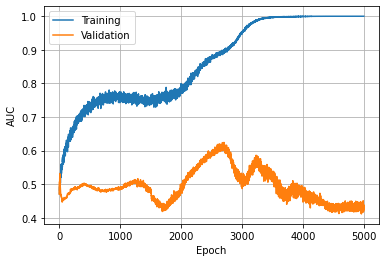

In [6]:

# Define Callbacks
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('AUC') == 1.0):
            print("\nReached AUC of 1 so cancelling training!")
            self.model.stop_training = True
            
overfit_callback = myCallback()

checkpoints = tf.keras.callbacks.ModelCheckpoint('Models/32_final_bestmodel_{}{}.h5'.format(domain, condition), 
                                                 monitor='val_AUC', 
                                                 save_best_only=True,
                                                 mode = 'max') # Mode = 'max' is important, otherwise the model with the lowest AUC is saved
#callbacks_list = [overfit_callback, checkpoints]
callbacks_list = [checkpoints]

# Train Model
trainHistory = viz_model.fit(trainset,
                             batch_size = batch_size, 
                             epochs=5000, 
                             callbacks = callbacks_list, 
                             validation_data=testset)

# Plot Train and validation AUCs
plt.plot(trainHistory.history['AUC'])
plt.plot(trainHistory.history['val_AUC'])
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'])
plt.grid()
plt.show()
 

### Save Model and History

In [7]:

# Save Model
viz_model.save('Models/32_final_{}{}'.format(domain, condition))

# Save TrainHistorya
with open('Models/32_trainHistory_final_{}{}.pkl'.format(domain, condition), 'wb') as f:
    pickle.dump(trainHistory, f)


2022-03-22 09:33:18.383398: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: Models/32_final__P__closed/assets
INFO:tensorflow:Assets written to: ram://b20f04f6-b9a2-43b5-947e-865685f32905/assets


### Save Model Predictions

In [4]:
# Load best-trained model (from ModelCheckpoint callback)
viz_model = keras.models.load_model('Models/32_final_bestmodel_{}{}.h5'.format(domain, condition))

# Predict with best-trained Model; List-comprehension for convenient Format
model_predictions = viz_model.predict(testset)
np.save("Predictions/32_prediction_%s%s.npy"%(domain, condition),[pred[0] for pred in model_predictions])

2022-03-22 20:35:08.999592: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302
2022-03-22 20:35:10.103019: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


## Plot AUC and Loss

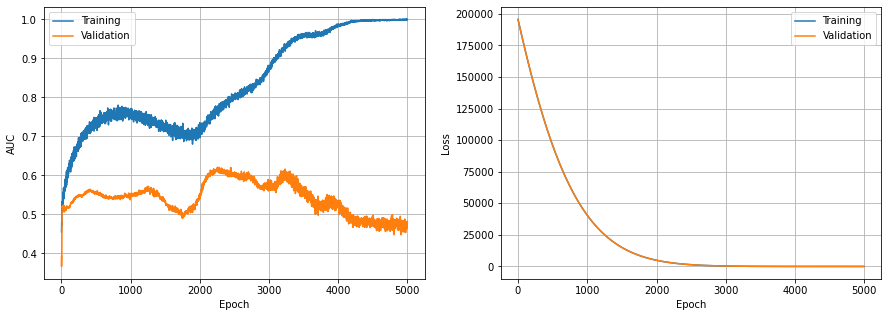

In [10]:
fig, ax = plt.subplots(1,2,figsize = (15,5))

ax[0].plot(trainHistory.history['accuracy'])
ax[0].plot(trainHistory.history['val_accuracy'])
ax[0].set_ylabel('AUC')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Training', 'Validation'])
ax[0].grid()
ax[1].plot(trainHistory.history['loss'][5:])
ax[1].plot(trainHistory.history['val_loss'][5:])
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Training', 'Validation'])
ax[1].grid()

plt.show()


# ROC-Curve and Confusion Matrix

In [5]:
# Load best-trained model
viz_model = keras.models.load_model('Models/32_final_bestmodel_{}{}.h5'.format(domain, condition))

# Predict with best-trained Model
model_predictions = viz_model.predict(testset)

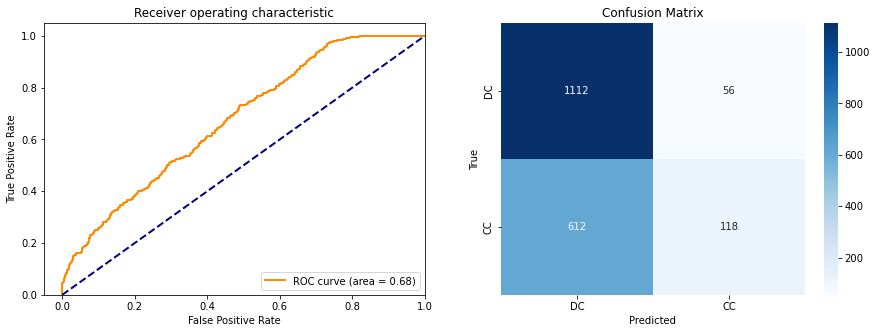

In [6]:
# Build arrays for GradCAM and predictions to inspect the network's decision making

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import seaborn as sns

test_targets = np.load("Data/target_test%s%s.npy"%(domain, condition))

pred = [i[0] for i in model_predictions]
fpr, tpr, _ = roc_curve(test_targets, pred)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(1,2,figsize = (15,5))

lw = 2
ax[0].plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)

ax[0].plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
ax[0].set_xlim([-0.05, 1.0])
ax[0].set_ylim([0.0, 1.05])
ax[0].set_xlabel("False Positive Rate")
ax[0].set_ylabel("True Positive Rate")
ax[0].set_title("Receiver operating characteristic")
ax[0].legend(loc="lower right")

# Confusion Matrix
predictions = [round(i[0]) for i in model_predictions]
cm = confusion_matrix(test_targets, predictions)
ax[1] = sns.heatmap(cm, annot=True, fmt="d", cmap = "Blues", xticklabels = ["DC","CC"], yticklabels = ["DC","CC"])
ax[1].set_ylabel("True")
ax[1].set_xlabel("Predicted")
ax[1].set_title("Confusion Matrix")

plt.show()
   
    

# Hyperparameter Tuning
(only relevant for model development and configuration)

In [ ]:
from sklearn.metrics import roc_curve, auc


# Fill in values that shall be checked in Hyperparameter Tuning
lr = [1e-5] # Learning rate
reg = [tf.keras.regularizers.l2(1)] # Regularization to be used
dropout = [0.5] # Dropout
second_layer = [True, False] #Whether to include the second Conv Layer
no_epochs = 1000
batch_size = 32
verbose = 0

minchange_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, min_delta = 0.001)

# List to store trainHistories
hist_list = []

# Build paramter grid from lists
from sklearn.model_selection import ParameterGrid
param_grid = ParameterGrid({'lr': lr, 'reg': reg, 'dropout': dropout, 'second_layer': second_layer})

# Iterate over parameters and run Model with chosen specifications
for params in param_grid:
    
    viz_model = tf.keras.models.Sequential()
    viz_model.add(layers.BatchNormalization())
    viz_model.add(layers.Conv2D(32, (5, 5), activation='relu'))
    viz_model.add(layers.MaxPooling2D((2, 2)))
    if params['second_layer']:
        viz_model.add(layers.BatchNormalization())
        viz_model.add(layers.Conv2D(32, (3, 3), activation='relu'))
        viz_model.add(layers.MaxPooling2D((2, 2)))
    viz_model.add(layers.BatchNormalization())
    viz_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    viz_model.add(layers.MaxPooling2D((2, 2)))
    viz_model.add(layers.BatchNormalization())
    viz_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    viz_model.add(layers.MaxPooling2D((2, 2)))
    viz_model.add(layers.BatchNormalization())
    viz_model.add(layers.Conv2D(128, (3, 3), activation='relu')) 
    viz_model.add(layers.GlobalAveragePooling2D())
    viz_model.add(layers.Dropout(params['dropout']))
    viz_model.add(layers.Dense(256, activation='relu')) 
    viz_model.add(layers.Dense(1, activation='sigmoid'))


    viz_model = add_regularization(viz_model, 
                                   initializer = keras.initializers.RandomNormal(stddev = 1.0, seed = 2705), 
                                   regularizer = params['reg'])

    adam = keras.optimizers.Adam(learning_rate=params['lr'])
    viz_model.compile(optimizer=adam, loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(from_logits=True, name = 'AUC'), 'accuracy'])
    trainHistory = viz_model.fit(trainset, batch_size = batch_size, epochs=no_epochs, validation_data=testset, callbacks = [minchange_callback, overfit_callback], verbose = verbose)
    
    hist_list.append(trainHistory)
    
    # Print what is being trained on currently
    print("LR: {}, Regularization: {}, Dropout: {}, AUC: {}, Val AUC: {}".format(params['lr'],
                                               params['reg'],
                                               params['dropout'],
                                               np.mean(trainHistory.history['AUC']), 
                                               np.mean(trainHistory.history['val_AUC'])))
    

In [ ]:

# Save trainHistories for later inspection
with open('Models/HPT_histories/32_trainhistories_{}{}.pkl'.format(domain, condition), 'wb') as f:
    pickle.dump(hist_list, f)
